In [37]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [38]:
warnings.filterwarnings(action="ignore",
                        message="^internal gelsd")
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})
pd.set_option("display.max_rows",
              None, 
              "display.max_columns",
              None)

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [39]:
def axes_log_conversion (list_of_values):
    list_num = []
    for i in list_of_values:
        list_num.append(str(int(round(((-10**(-i) + 1) * 100),0))) + '%')
    return list_num

In [40]:
df = pd.read_csv('../data/image-classification-on-imagenet.csv',
                 usecols=['name',
                          'year',
                          'flops',
                          'multiadds',
                          'hardware_burden',
                          'network_operations',
                           '(TOP 1 score)'])[3:].reset_index(drop=True)

In [41]:
df = df.astype({'year': 'int64',
                'flops': 'float64',
                'multiadds': 'float64',
                'hardware_burden': 'float64',
                'network_operations': 'float64',
                '(TOP 1 score)': 'float64'})

df['ops_forward_pass'] = df['flops'].combine_first(df['multiadds'] * 2)
df['top1_error_percent'] = (100 - df['(TOP 1 score)'].astype(float))/100

df = df[['name', 
         'year',
         'top1_error_percent',
         'ops_forward_pass', 
         'network_operations', 
         'hardware_burden']]

In [42]:
df.head(10)

,name,year,top1_error_percent,ops_forward_pass,network_operations,hardware_burden
0,CoCa,2022,0.0900,NaN,NaN,2.400000e+23
1,Model soups (ViT-G/14),2022,0.0906,NaN,NaN,NaN
2,ViT-G/14,2021,0.0955,NaN,NaN,NaN
3,ViT-MoE-15B (Every-2),2021,0.0965,NaN,3.390000e+22,7.600000e+22
4,Meta Pseudo Labels (EfficientNet-L2),2020,0.0980,NaN,NaN,1.000000e+23
5,SwinV2-G,2021,0.0983,NaN,NaN,NaN
6,Florence-CoSwin-H,2021,0.0995,NaN,NaN,NaN
7,TokenLearner L/8 (24+11),2021,0.1113,NaN,NaN,NaN
8,ALIGN (EfficientNet-L2),2021,0.1136,NaN,NaN,NaN
9,EfficientNet-L2-475 (SAM),2020,0.1139,NaN,NaN,NaN


In [43]:
df.head()

,name,year,top1_error_percent,ops_forward_pass,network_operations,hardware_burden
0,CoCa,2022,0.0900,NaN,NaN,2.400000e+23
1,Model soups (ViT-G/14),2022,0.0906,NaN,NaN,NaN
2,ViT-G/14,2021,0.0955,NaN,NaN,NaN
3,ViT-MoE-15B (Every-2),2021,0.0965,NaN,3.390000e+22,7.600000e+22
4,Meta Pseudo Labels (EfficientNet-L2),2020,0.0980,NaN,NaN,1.000000e+23


## Operations per Forward Pass

In [44]:
error__ops_forward_pass__poly = ols('I(np.log10(top1_error_percent)) ~ I(np.log10(ops_forward_pass))', data=df).fit()
print(error__ops_forward_pass__poly.summary()) 

                                   OLS Regression Results                                  
Dep. Variable:     I(np.log10(top1_error_percent))   R-squared:                       0.606
Model:                                         OLS   Adj. R-squared:                  0.603
Method:                              Least Squares   F-statistic:                     166.4
Date:                             Thu, 04 Aug 2022   Prob (F-statistic):           1.33e-23
Time:                                     16:00:49   Log-Likelihood:                 159.17
No. Observations:                              110   AIC:                            -314.3
Df Residuals:                                  108   BIC:                            -308.9
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                    coef    std err          t      P>|t|      [

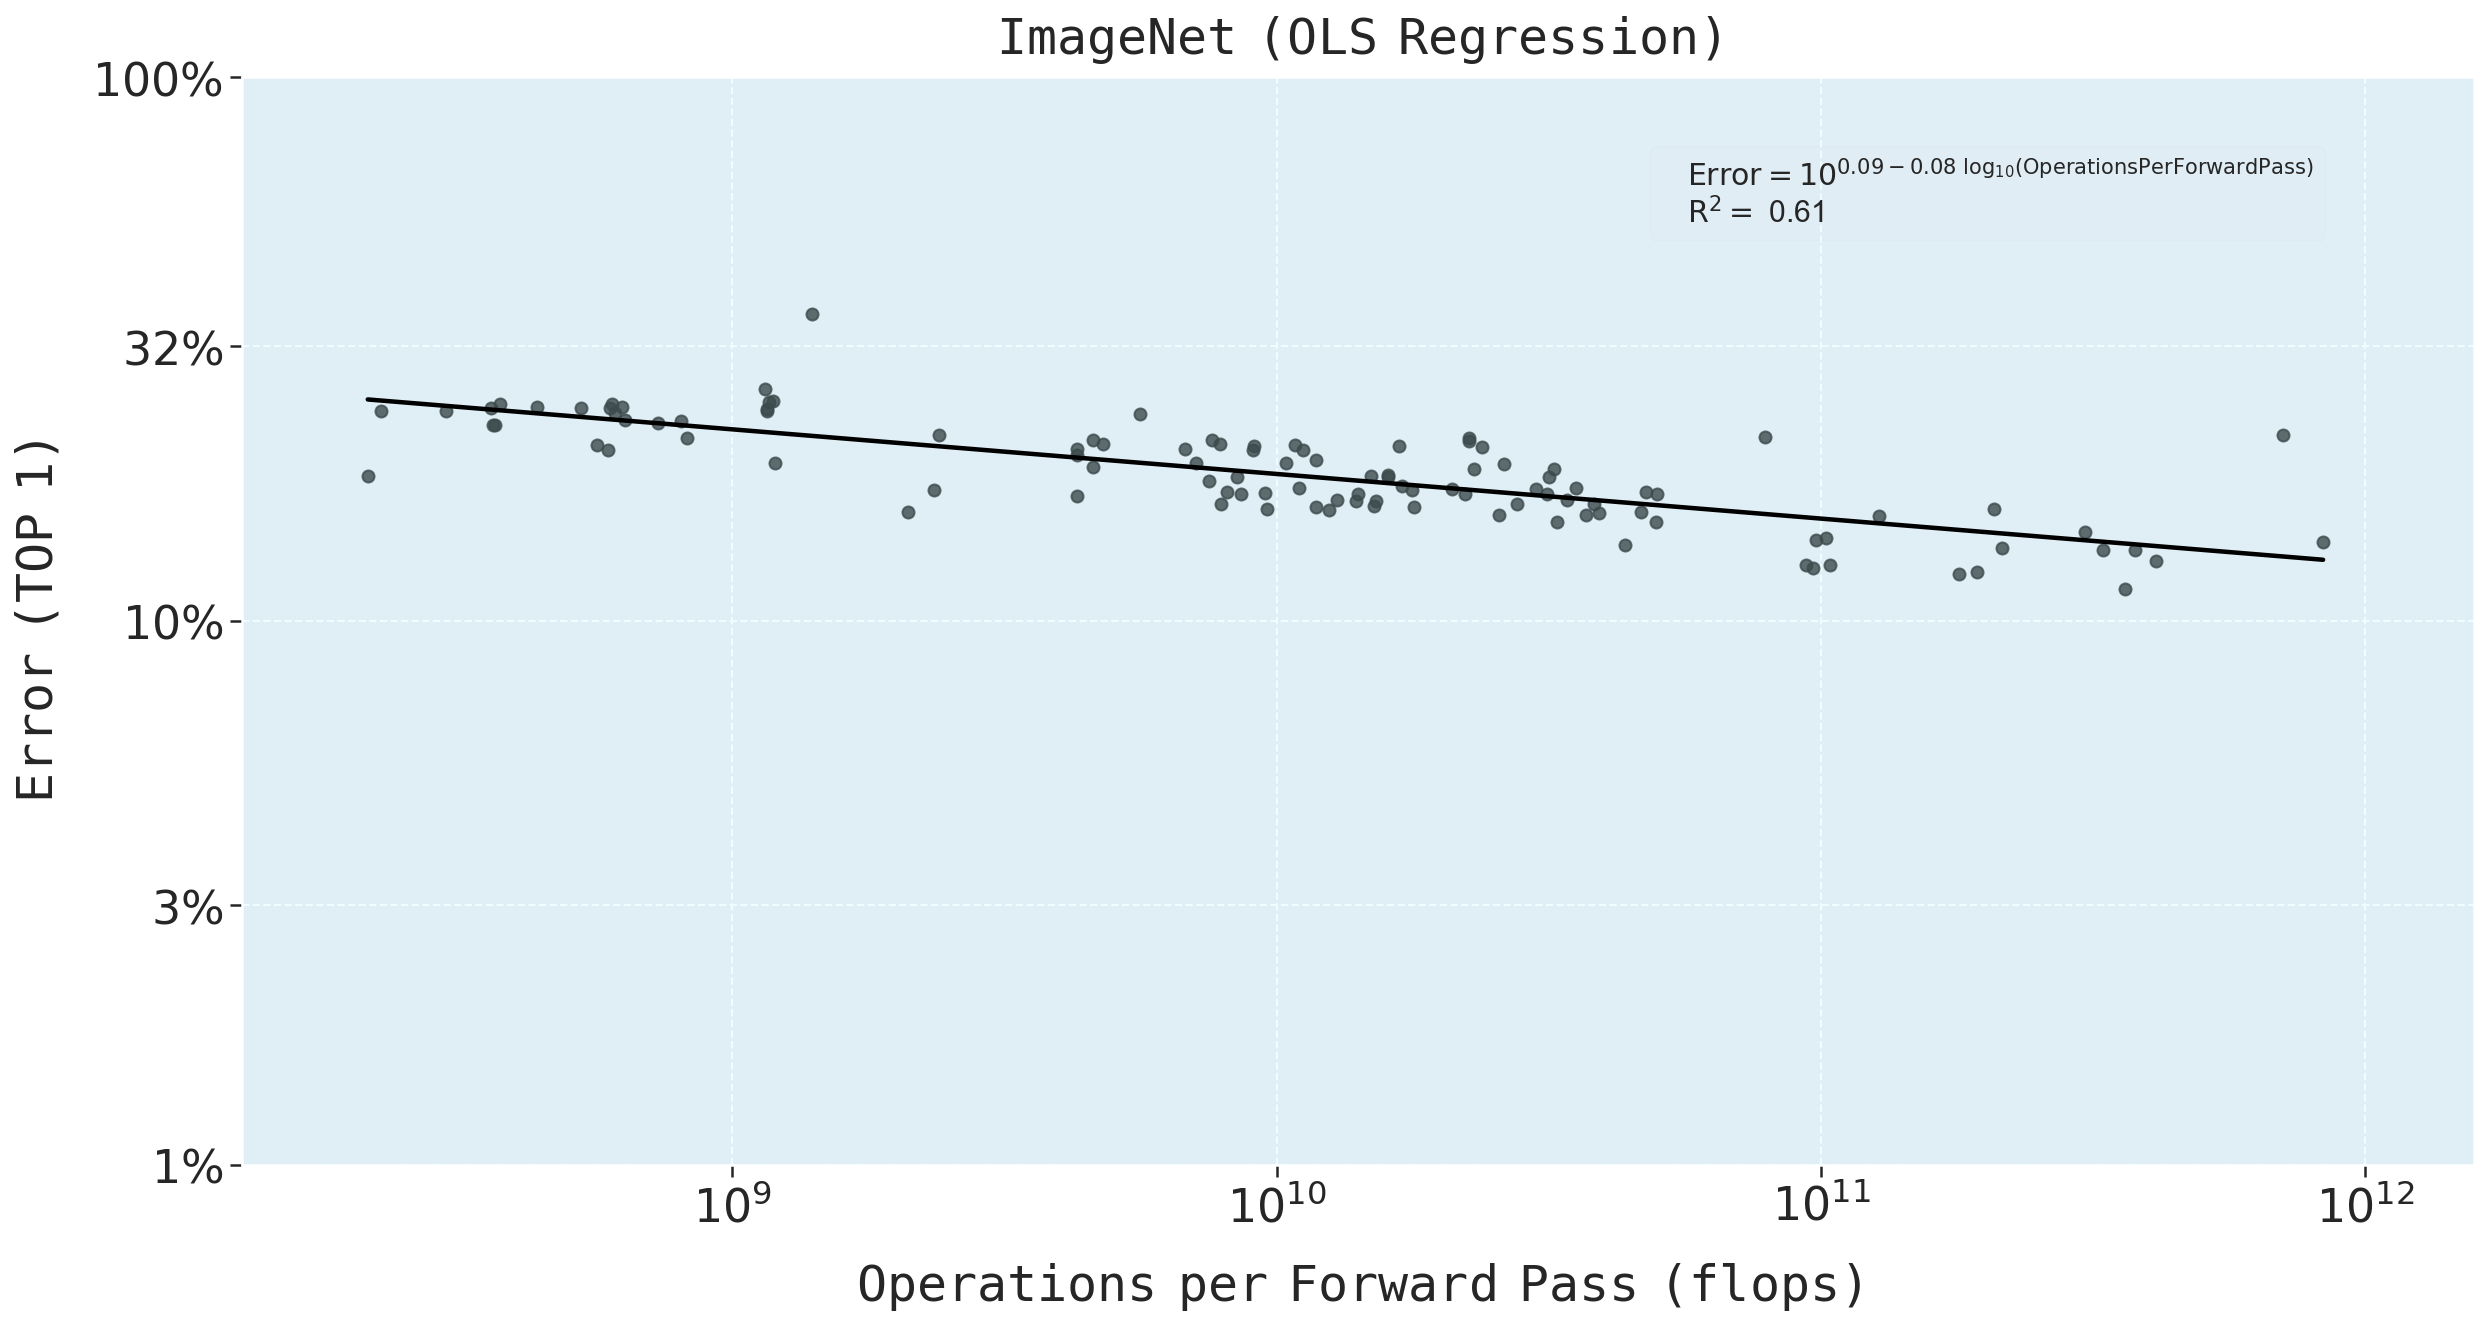

In [45]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['ops_forward_pass']),
            y=np.log10(df['top1_error_percent']),
            color='black',
            ci = False,
            label=r'$\mathrm{Error}= 10^{' +
                  str(round(error__ops_forward_pass__poly.params[0],2)) +
                  str(round(error__ops_forward_pass__poly.params[1],2)) +
                  '\ \mathrm{log_{10}(OperationsPerForwardPass)} }$' + '\n' + 
                  r'$\mathrm{R^{2}}=\ $' +
                  str(round(error__ops_forward_pass__poly.rsquared,2)))

plt.title('$\mathtt{ImageNet\ \ (OLS\ \ Regression)}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{Error\ \ (TOP\ \ 1)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Operations\ \ per\ \ Forward\ \ Pass \ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.94,.95),
           handlelength=0,
           framealpha =.03,
           fontsize=15,
           markerscale=0)

plt.axhspan(-2, -0, 
            color="#c9f9ff",
            alpha=0.3)

x = np.arange(9,13,1)

y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

x_label = ['$10^{9}$',
           '$10^{10}$',
           '$10^{11}$',
           '$10^{12}$']

y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

plt.xlim(8.1, 12.2)

plt.ylim(-2, -0)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

## Network Operations

In [46]:
error__network_ops__poly = ols('I(np.log10(top1_error_percent)) ~ I(np.log10(network_operations))', data=df).fit()
print(error__network_ops__poly.summary()) 

                                   OLS Regression Results                                  
Dep. Variable:     I(np.log10(top1_error_percent))   R-squared:                       0.720
Model:                                         OLS   Adj. R-squared:                  0.717
Method:                              Least Squares   F-statistic:                     193.2
Date:                             Thu, 04 Aug 2022   Prob (F-statistic):           1.90e-22
Time:                                     16:00:50   Log-Likelihood:                 121.88
No. Observations:                               77   AIC:                            -239.8
Df Residuals:                                   75   BIC:                            -235.1
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                      coef    std err          t      P>|t|     

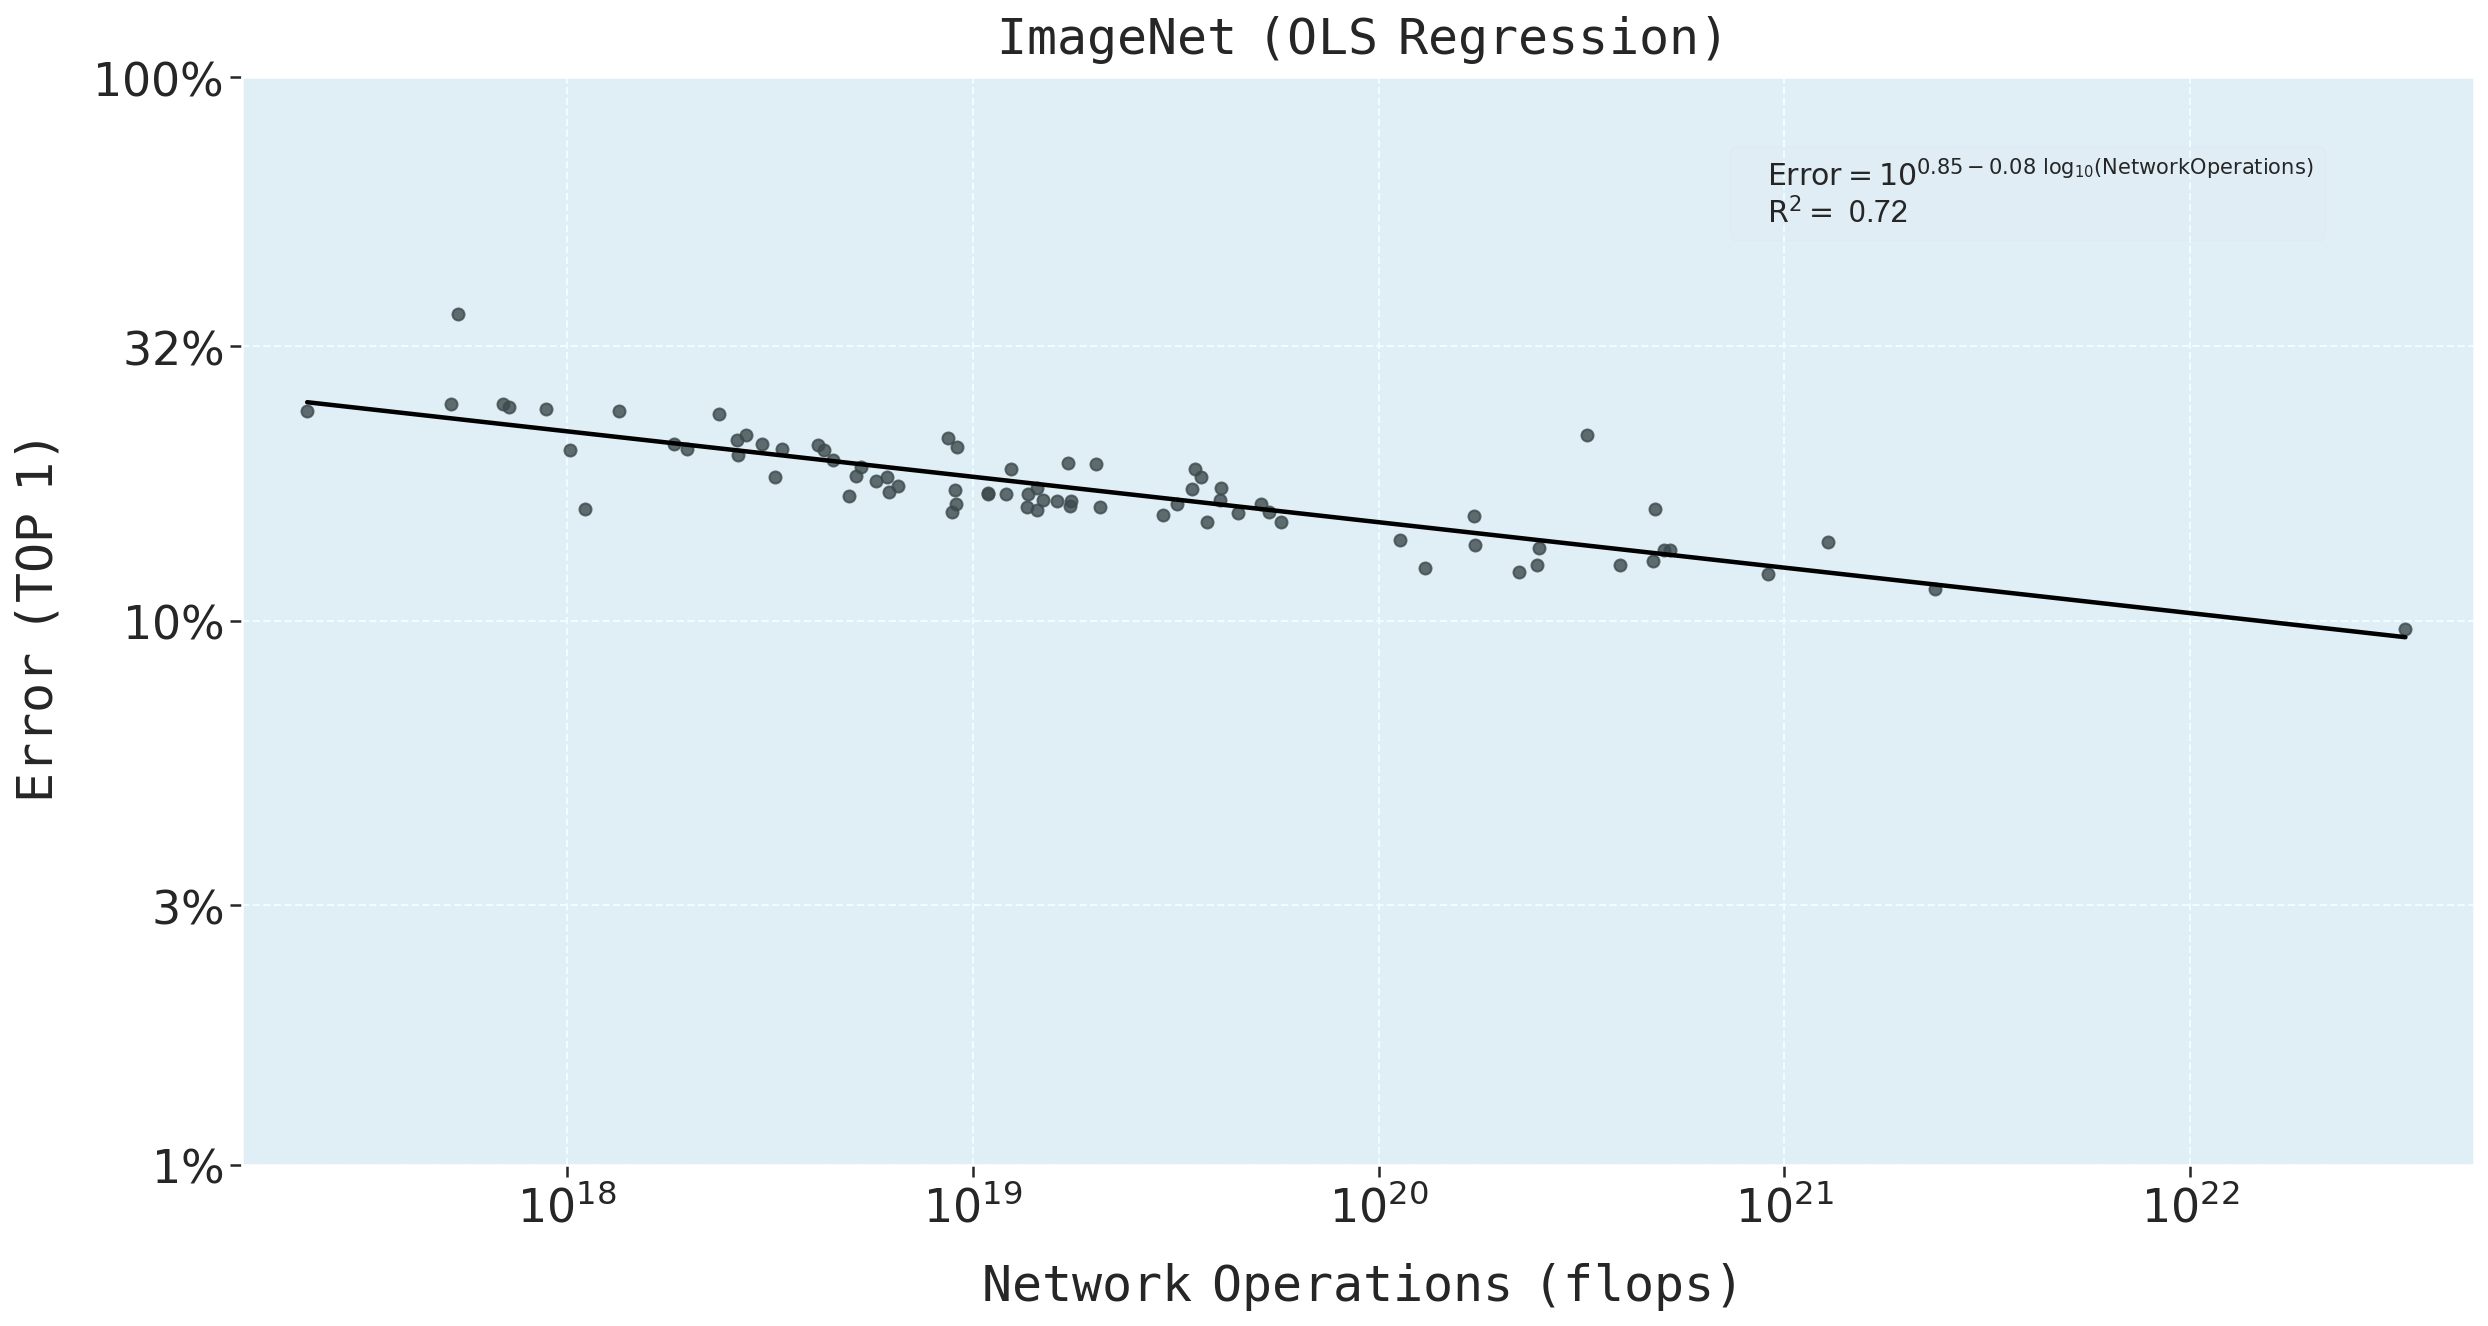

In [47]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['network_operations']),
            y=np.log10(df['top1_error_percent']),
            color='black',
            ci = False,
            label=r'$\mathrm{Error}= 10^{' +
                  str(round(error__network_ops__poly.params[0],2)) +
                  str(round(error__network_ops__poly.params[1],2)) +
                  '\ \mathrm{log_{10}(NetworkOperations)} }$' + '\n' + 
                  r'$\mathrm{R^{2}}=\ $' + 
                  str(round(error__network_ops__poly.rsquared,2)))

plt.title('$\mathtt{ImageNet\ \ (OLS\ \ Regression)}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{Error\ \ (TOP\ \ 1)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')
           
plt.xlabel("$\mathtt{Network\ \ Operations\ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.94, .95),
                    handlelength=0,
                    framealpha=.03,
                    fontsize=15,
                    markerscale=0)

plt.axhspan(-2, -0, 
            color="#c9f9ff",
            alpha=0.3)

x = np.arange(18,23,1)

y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

x_label = ['$10^{18}$',
           '$10^{19}$',
           '$10^{20}$',
           '$10^{21}$',
           '$10^{22}$']

y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

plt.xlim(17.2, 22.7)

plt.ylim(-2, -0)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

## Hardware Burden

In [48]:
error__hw_burden__poly = ols('I(np.log10(top1_error_percent)) ~ I(np.log10(hardware_burden))', data=df).fit()
print(error__hw_burden__poly.summary()) 

                                   OLS Regression Results                                  
Dep. Variable:     I(np.log10(top1_error_percent))   R-squared:                       0.766
Model:                                         OLS   Adj. R-squared:                  0.759
Method:                              Least Squares   F-statistic:                     111.4
Date:                             Thu, 04 Aug 2022   Prob (F-statistic):           2.87e-12
Time:                                     16:00:50   Log-Likelihood:                 42.843
No. Observations:                               36   AIC:                            -81.69
Df Residuals:                                   34   BIC:                            -78.52
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

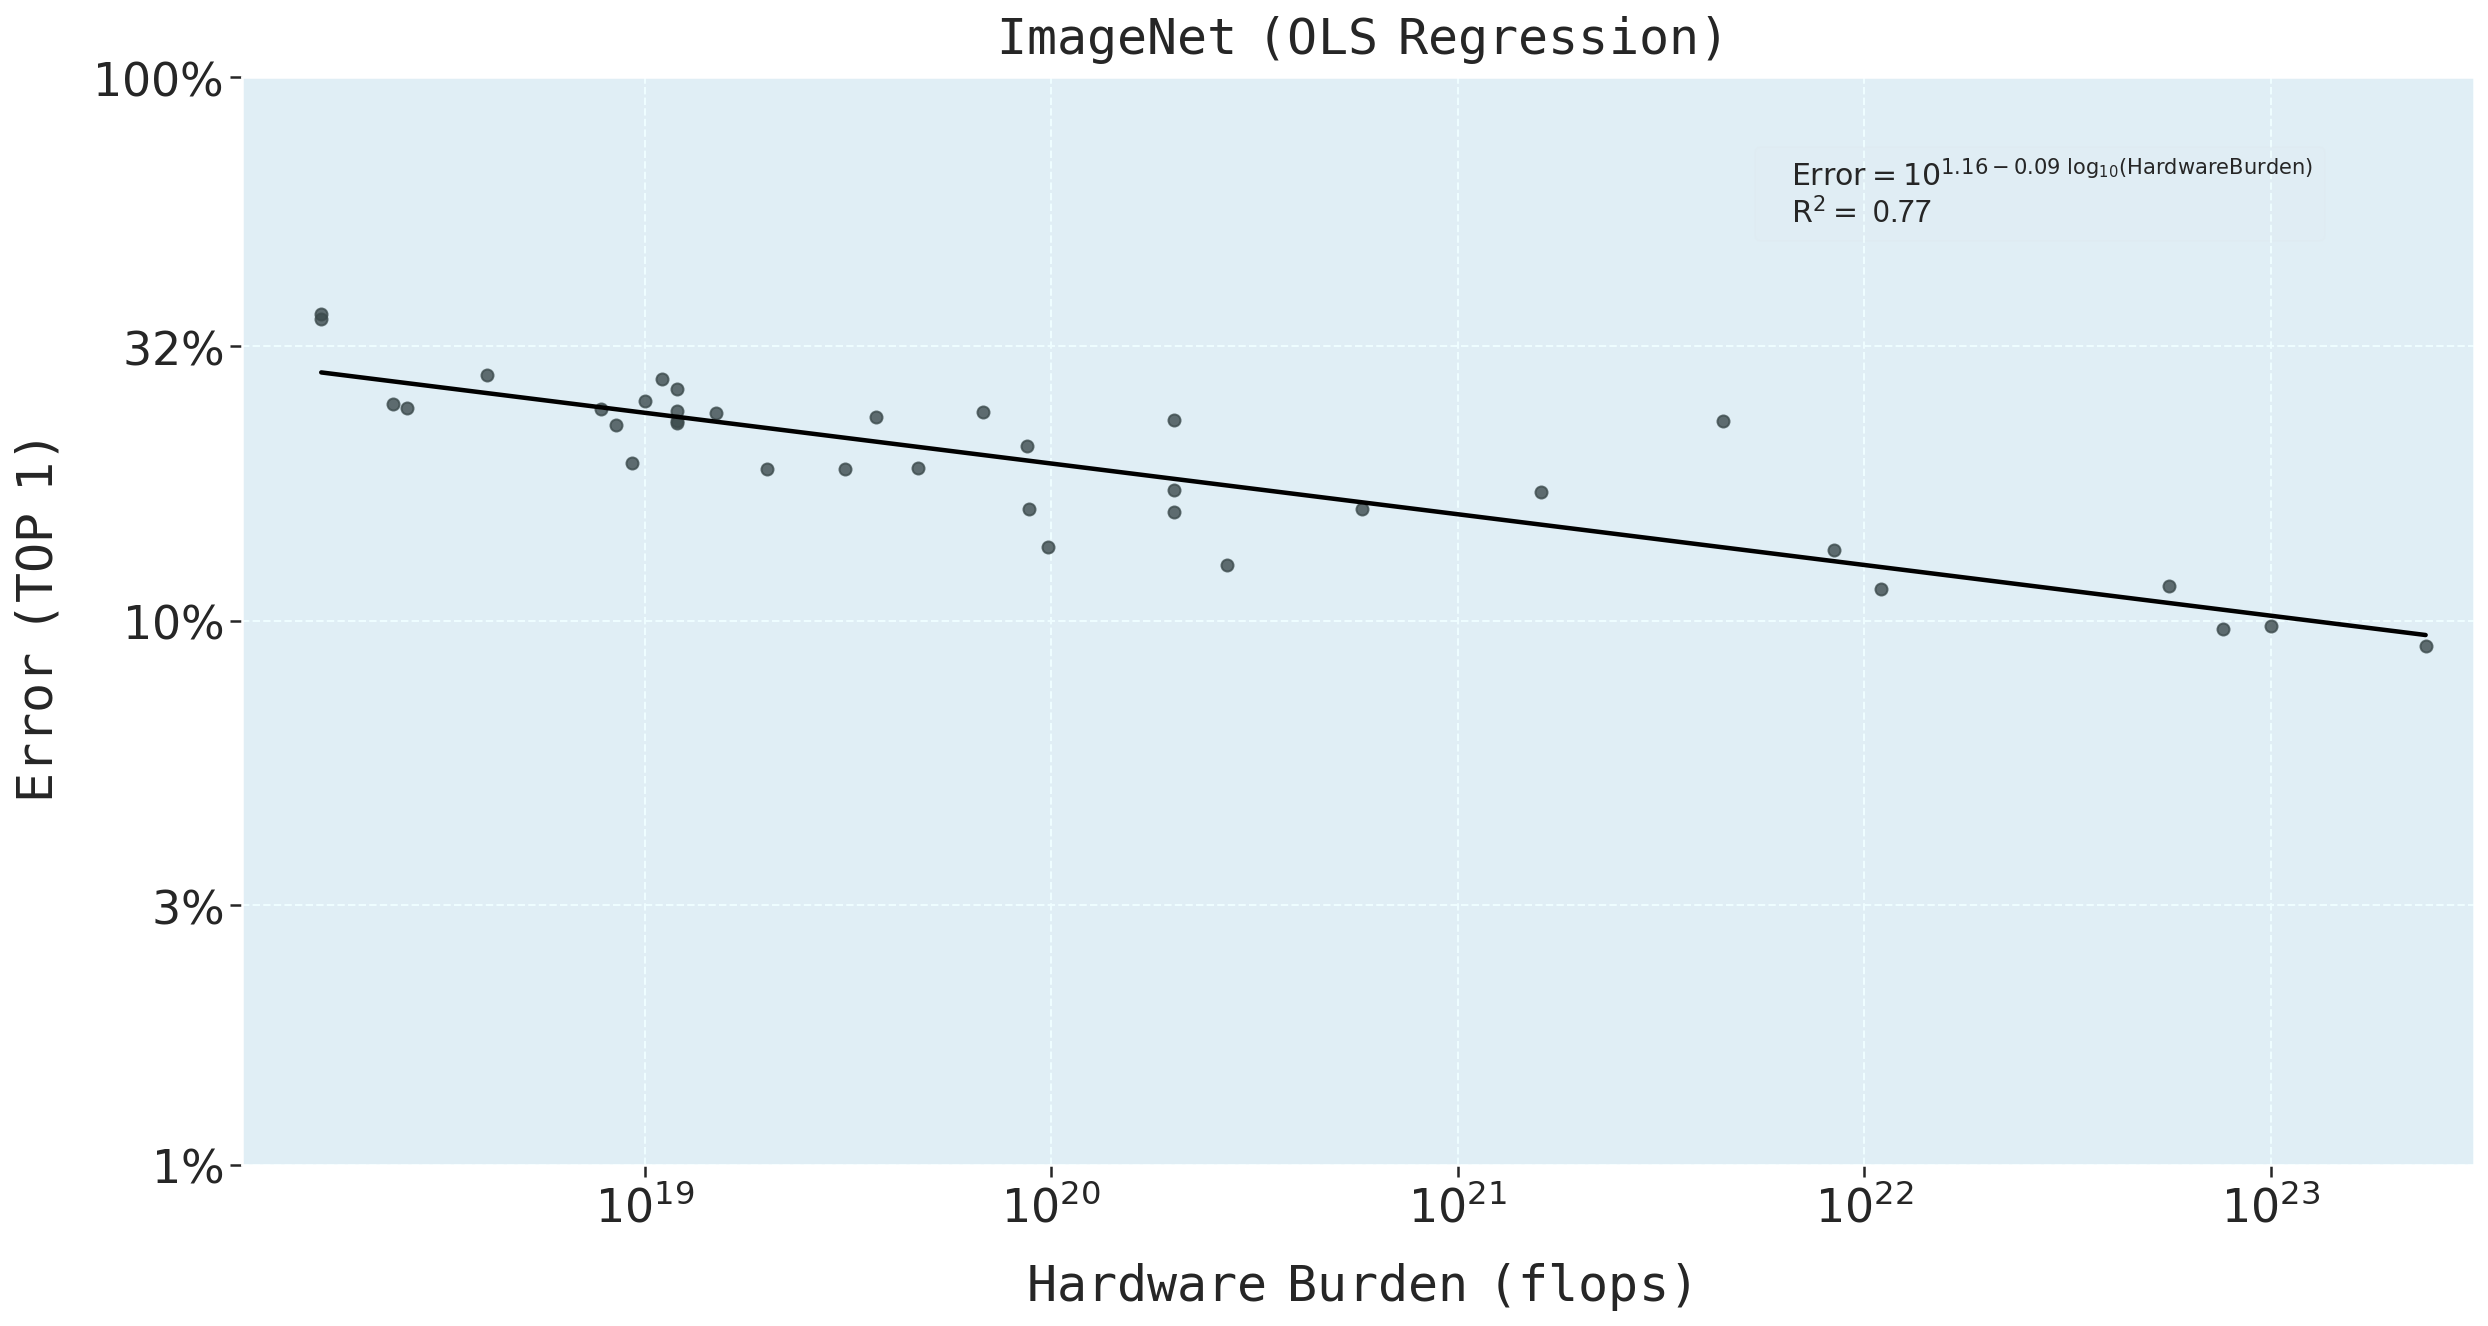

In [49]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['hardware_burden']),
            y=np.log10(df['top1_error_percent']),
            color='black',
            ci = False,
            label=r'$\mathrm{Error}= 10^{' +
                  str(round(error__hw_burden__poly.params[0],2)) +
                  str(round(error__hw_burden__poly.params[1],2)) +
                  '\ \mathrm{log_{10}(HardwareBurden)} }$' + '\n' + 
                  r'$\mathrm{R^{2}}=\ $' +
                  str(round(error__hw_burden__poly.rsquared,2)))

plt.title('$\mathtt{ImageNet\ \ (OLS\ \ Regression)}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{Error\ \ (TOP\ \ 1)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Hardware\ \ Burden\ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.94,.95),
           handlelength=0,
           framealpha =.03,
           fontsize=15,
           markerscale=0)

plt.axhspan(-2, -0,
            color="#c9f9ff",
            alpha=0.3)

x = np.arange(19,24,1)

y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

x_label = ['$10^{19}$',
           '$10^{20}$',
           '$10^{21}$',
           '$10^{22}$',
           '$10^{23}$']

y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

plt.xlim(18.01, 23.5)

plt.ylim(-2,-0)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

## Normalizing to Alexnet

In [50]:
alexnet_data = df.loc[df['name'].values == 'AlexNet']

df['ops_forward_pass_alexnet_norm'] = df['ops_forward_pass']/alexnet_data['ops_forward_pass'].values
df['network_ops_alexnet_norm'] = df['network_operations']/alexnet_data['network_operations'].values
df['hw_burden_alexnet_norm'] = df['hardware_burden']/alexnet_data['hardware_burden'].values

### Operations per Forward Pass

In [51]:
ops_forward_pass__alexnet_norm__poly = ols('I(np.log10(top1_error_percent)) ~ I(np.log10(ops_forward_pass_alexnet_norm))', data=df).fit()
print(ops_forward_pass__alexnet_norm__poly.summary()) 

                                   OLS Regression Results                                  
Dep. Variable:     I(np.log10(top1_error_percent))   R-squared:                       0.606
Model:                                         OLS   Adj. R-squared:                  0.603
Method:                              Least Squares   F-statistic:                     166.4
Date:                             Thu, 04 Aug 2022   Prob (F-statistic):           1.33e-23
Time:                                     16:00:51   Log-Likelihood:                 159.17
No. Observations:                              110   AIC:                            -314.3
Df Residuals:                                  108   BIC:                            -308.9
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                                 coef    std err          t     

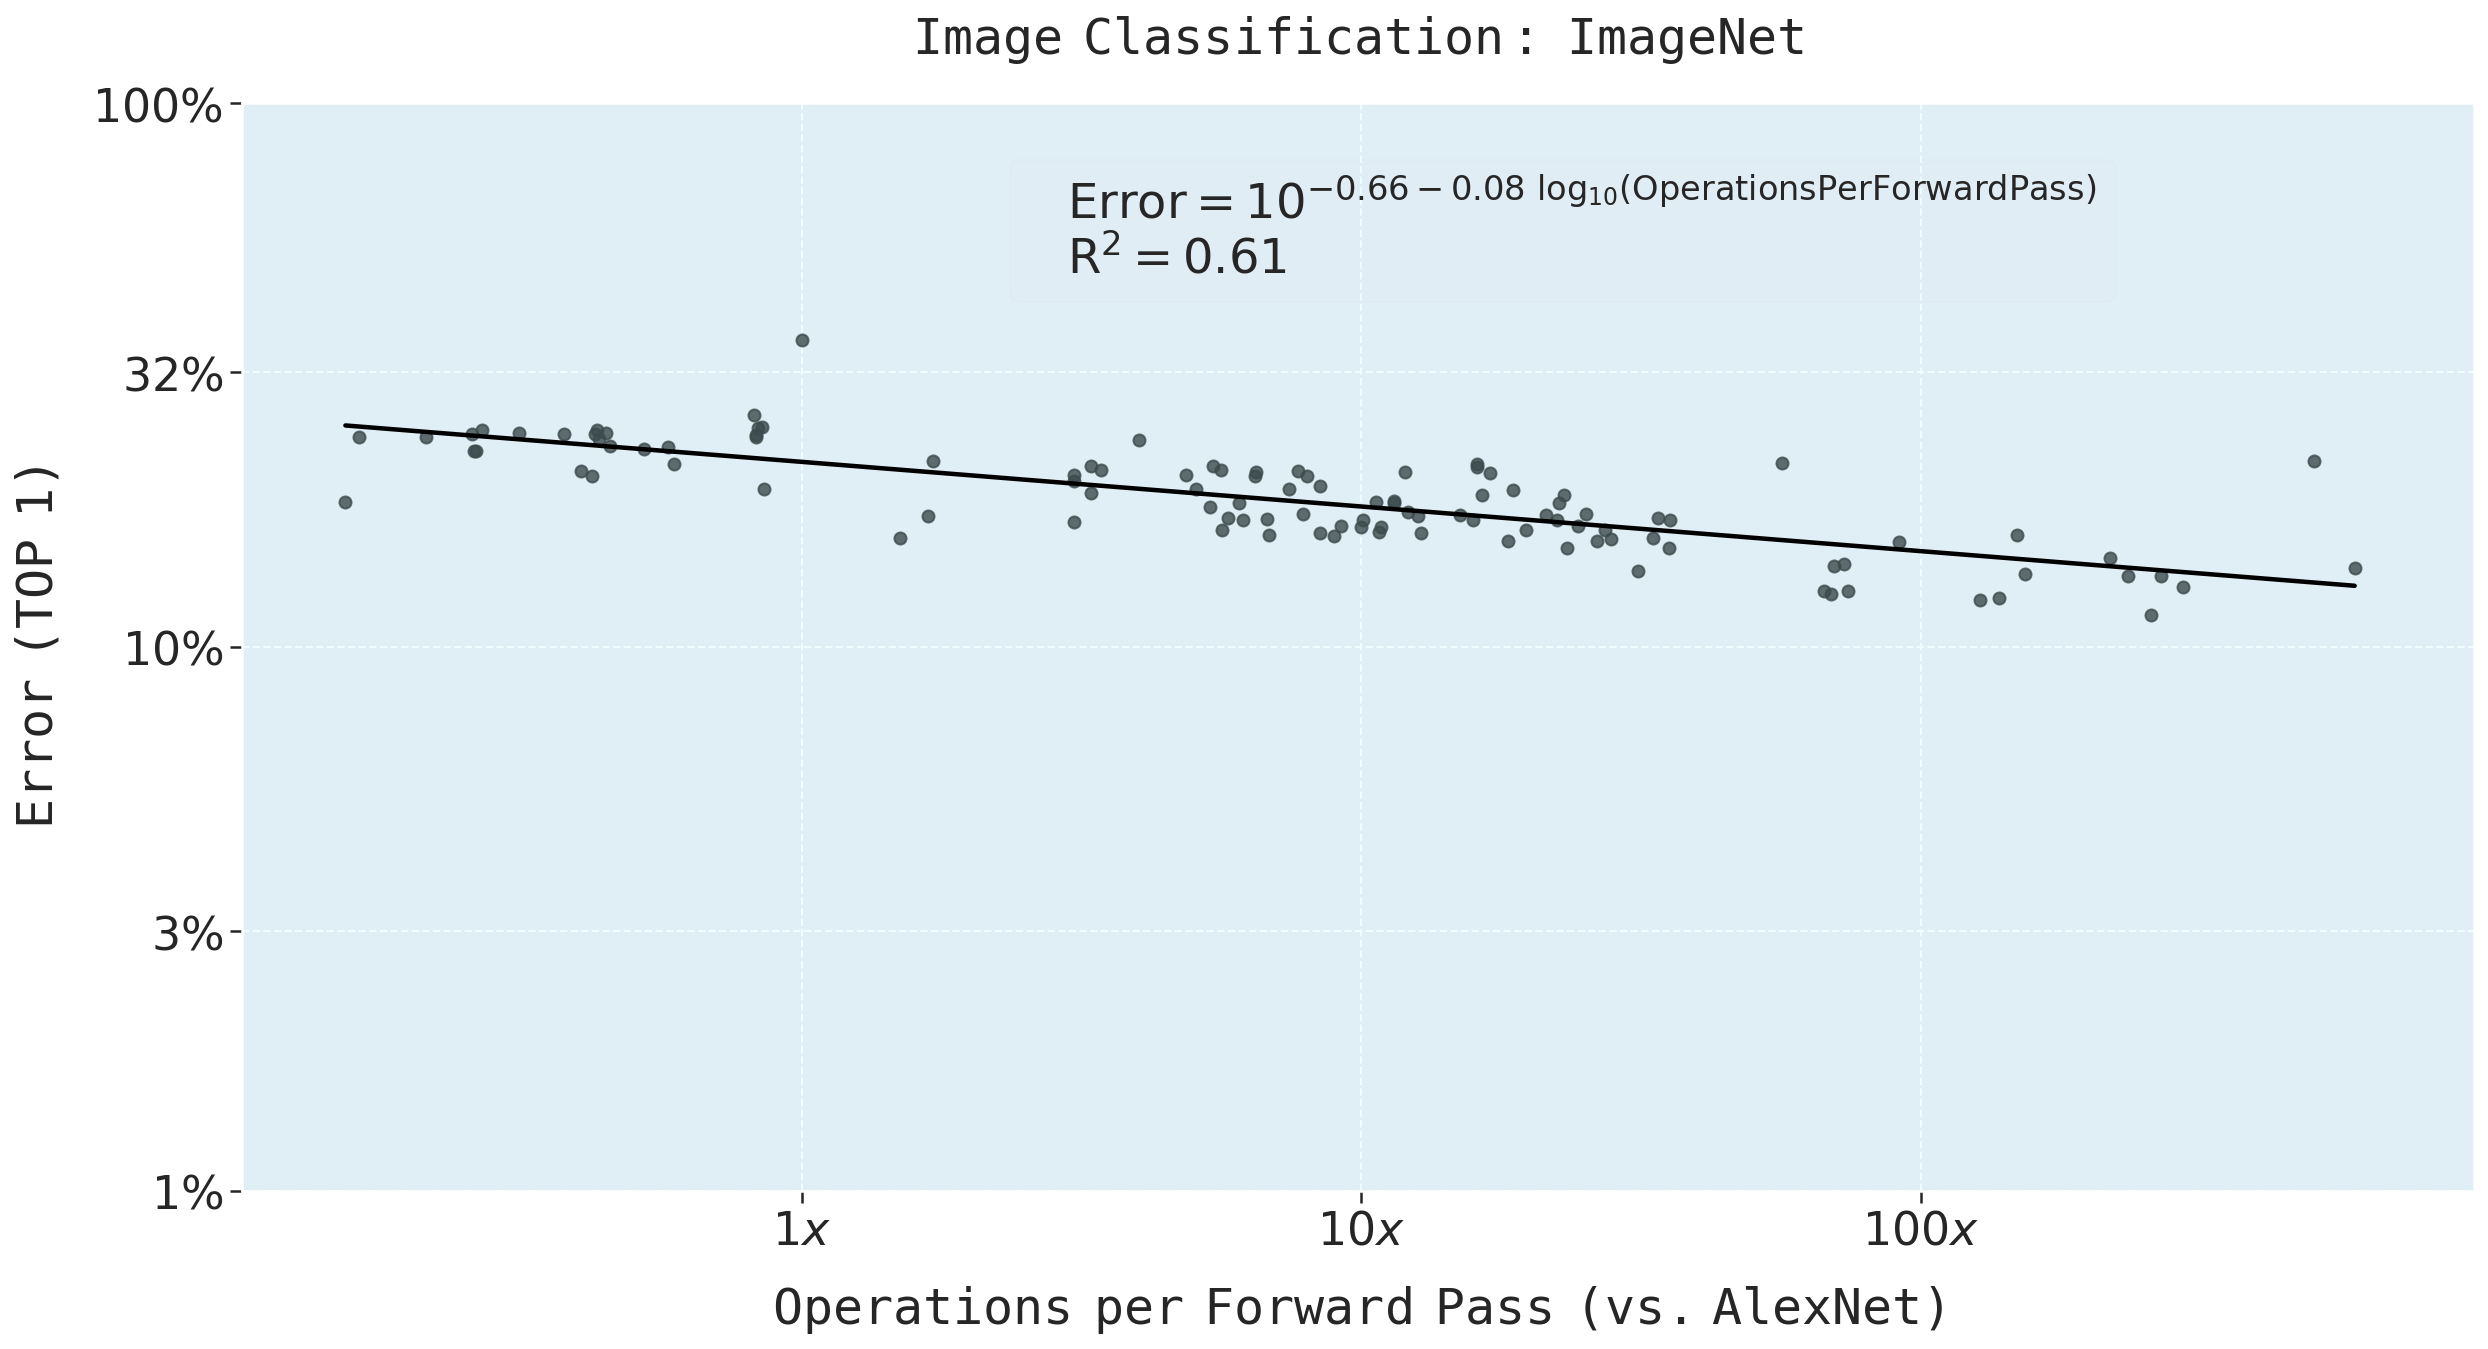

In [52]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['ops_forward_pass_alexnet_norm']),
            y=np.log10(df['top1_error_percent']),
            color='black',
            ci = False,
            line_kws={'label':r'$\mathrm{Error}= 10^{' +
                      str(round(ops_forward_pass__alexnet_norm__poly.params[0],2)) +
                      str(round(ops_forward_pass__alexnet_norm__poly.params[1],2)) +
                      '\ \mathrm{log_{10}(OperationsPerForwardPass)} }$' + '\n' + 
                      r'$\mathrm{R^{2}}= ' +
                      str(round(ops_forward_pass__alexnet_norm__poly.rsquared,2)) + '$'})

plt.title('$\mathtt{Image\ \ Classification:\ \ ImageNet}$',
          fontsize=25,
          weight='bold',
          pad=25)

plt.ylabel("$\mathtt{Error\ \ (TOP\ \ 1)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Operations\ \ per\ \ Forward\ \ Pass\ \ (vs.\ AlexNet)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.85,.97),
           handlelength=0,
           framealpha =.03,
           fontsize=24,
           markerscale=0)

plt.axhspan(-2, 0,
            color="#c9f9ff", 
            alpha=0.3)

x = np.arange(0,3,1)
y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

x_label = ['$1x$',
           '$10x$',
           '$100x$']

y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

plt.xlim(-1, 2.99)

plt.ylim(-2,0)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

### Network Operations

In [53]:
network_ops__alexnet_norm__poly = ols('I(np.log10(top1_error_percent)) ~ I(np.log10(network_ops_alexnet_norm))', data=df).fit()
print(network_ops__alexnet_norm__poly.summary()) 

                                   OLS Regression Results                                  
Dep. Variable:     I(np.log10(top1_error_percent))   R-squared:                       0.720
Model:                                         OLS   Adj. R-squared:                  0.717
Method:                              Least Squares   F-statistic:                     193.2
Date:                             Thu, 04 Aug 2022   Prob (F-statistic):           1.90e-22
Time:                                     16:00:51   Log-Likelihood:                 121.88
No. Observations:                               77   AIC:                            -239.8
Df Residuals:                                   75   BIC:                            -235.1
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                            coef    std err          t      P>|t

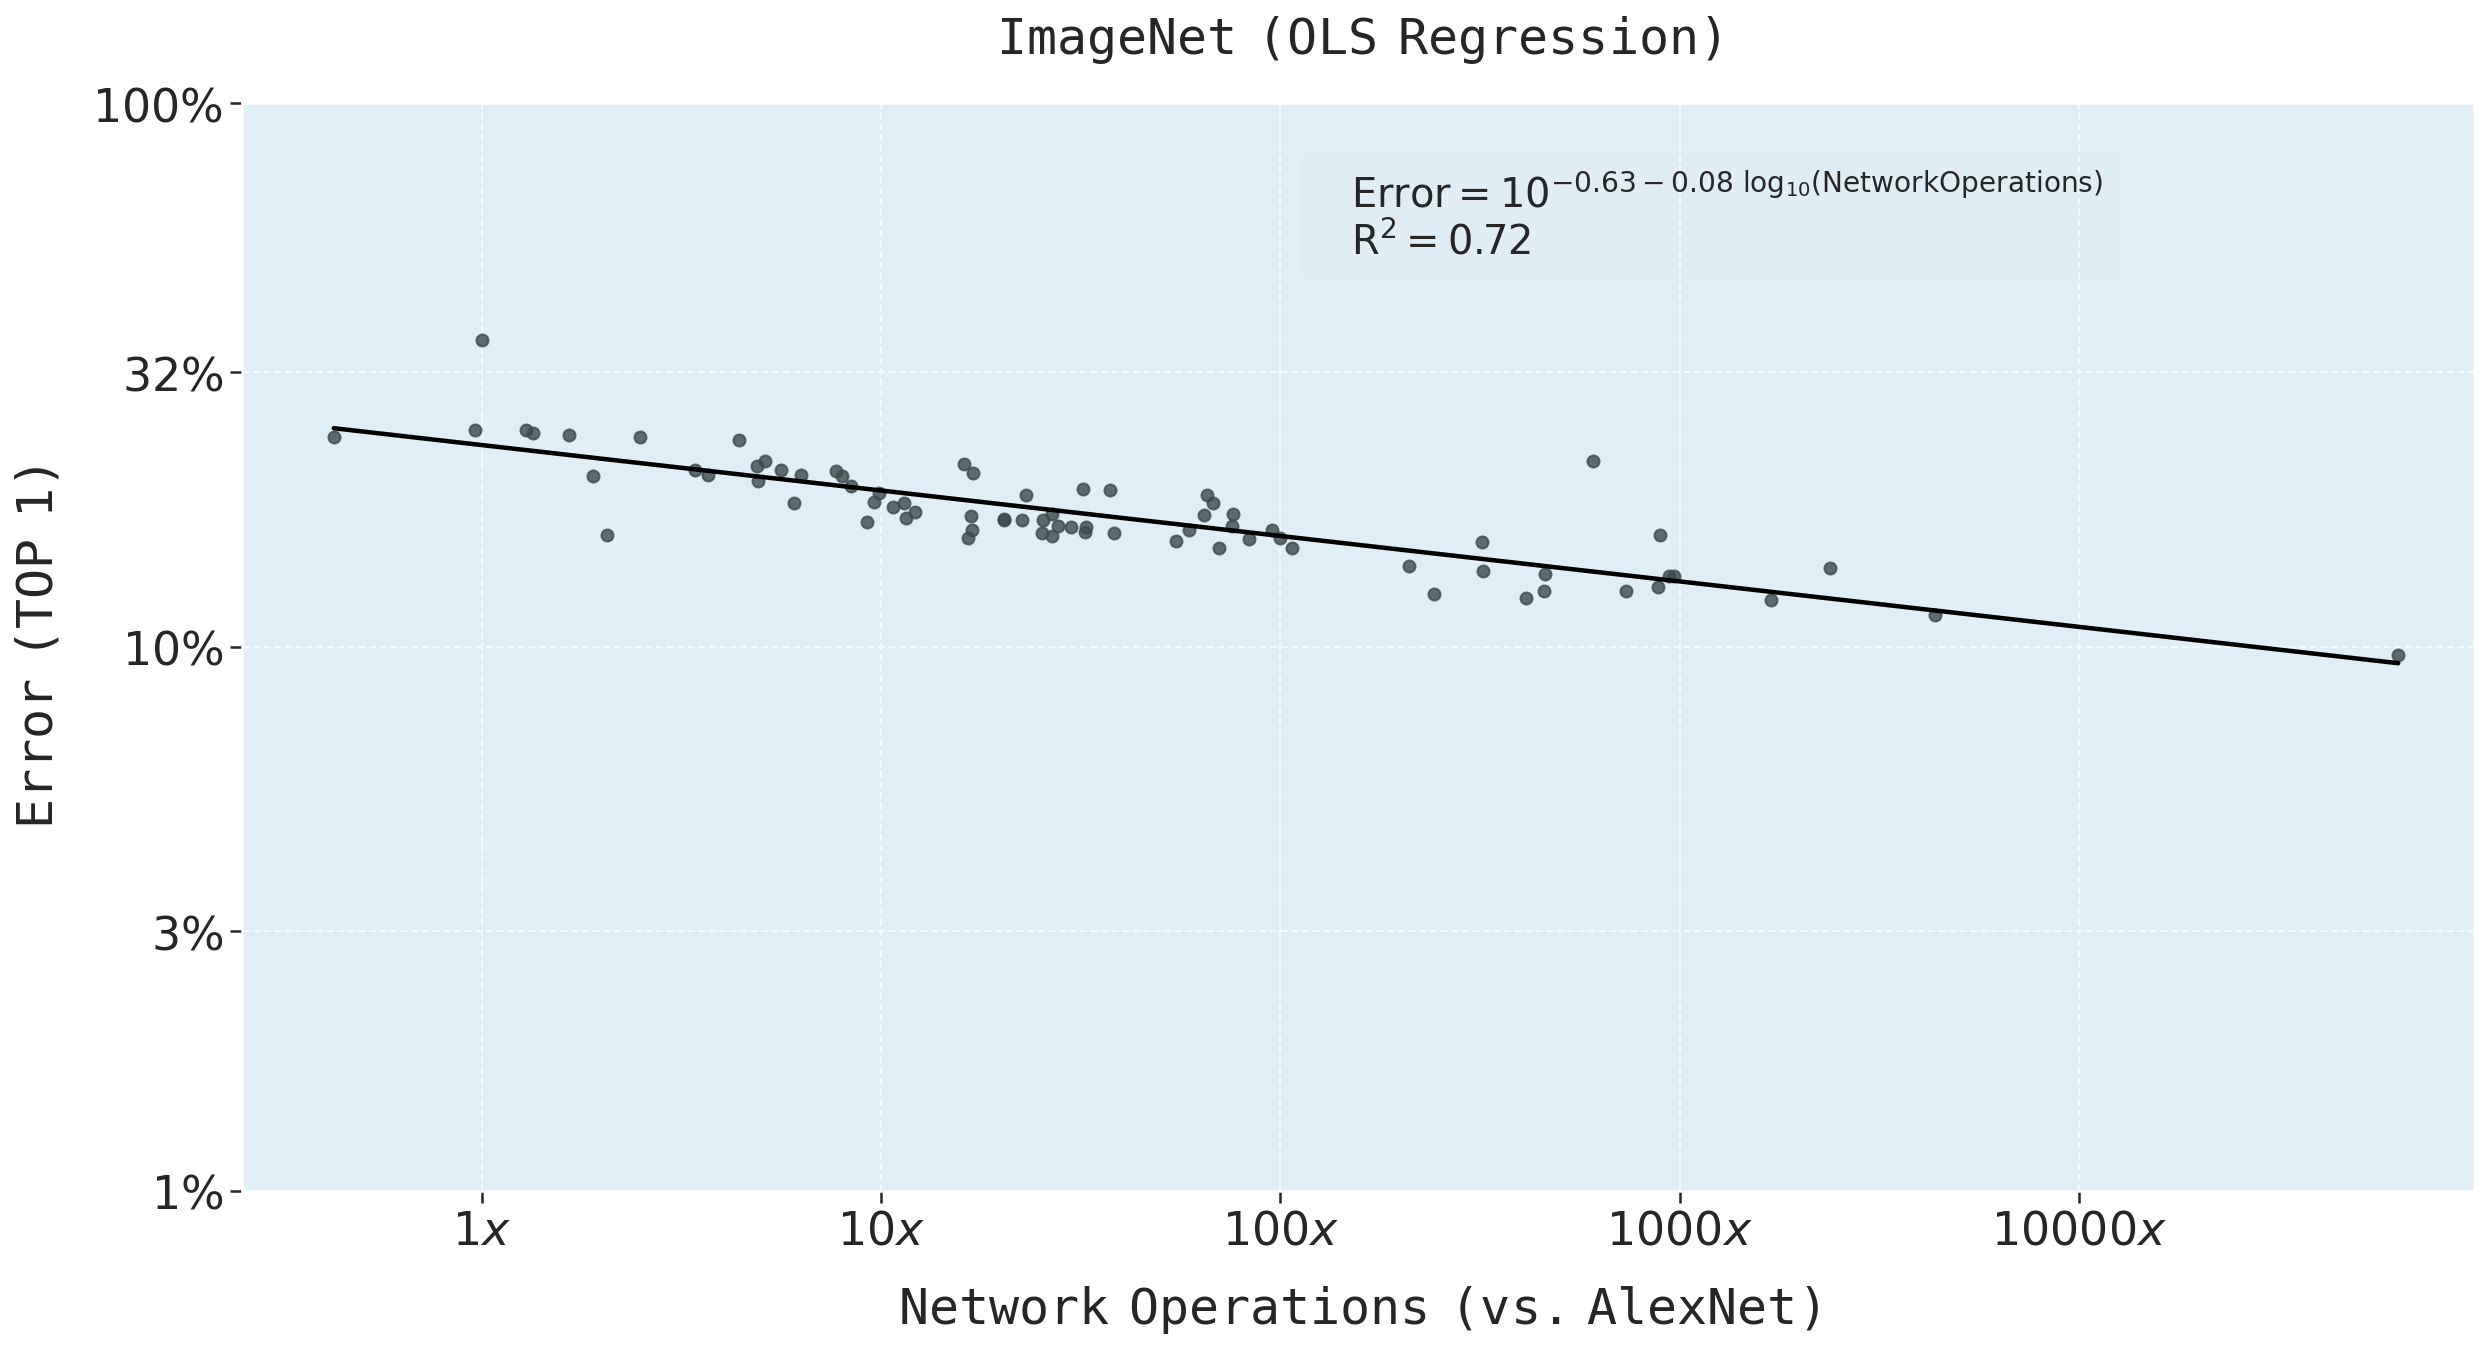

In [54]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['network_ops_alexnet_norm']),
            y=np.log10(df['top1_error_percent']),
            color='black',
            ci = False,
            line_kws={'label':r'$\mathrm{Error}= 10^{' +
                      str(round(network_ops__alexnet_norm__poly.params[0],2)) +
                      str(round(network_ops__alexnet_norm__poly.params[1],2)) +
                      '\ \mathrm{log_{10}(NetworkOperations)} }$' + '\n' + 
                      r'$\mathrm{R^{2}}= ' +
                      str(round(network_ops__alexnet_norm__poly.rsquared,2)) + '$'})

plt.title('$\mathtt{ImageNet\ \ (OLS\ \ Regression)}$',
          fontsize=25,
          weight='bold',
          pad=25)

plt.ylabel("$\mathtt{Error\ \ (TOP\ \ 1)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Network\ \ Operations\ \ (vs.\ AlexNet)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.85,.97),
           handlelength=0,
           framealpha =.03,
           fontsize=20,
           markerscale=0)

plt.axhspan(-2, 0, 
            color="#c9f9ff", 
            alpha=0.3)

x = np.arange(0,5,1)

y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

x_label = ['$1x$',
           '$10x$',
           '$100x$',
           '$1000x$',
           '$10000x$']

y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

plt.xlim(-.6, 4.99)

plt.ylim(-2, 0)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

In [55]:
network_ops__alexnet_norm__exp = ols('I(top1_error_percent) ~ I(np.log10(network_ops_alexnet_norm))', data=df).fit()
print(network_ops__alexnet_norm__exp.summary()) 

                              OLS Regression Results                             
Dep. Variable:     I(top1_error_percent)   R-squared:                       0.628
Model:                               OLS   Adj. R-squared:                  0.623
Method:                    Least Squares   F-statistic:                     126.7
Date:                   Thu, 04 Aug 2022   Prob (F-statistic):           8.95e-18
Time:                           16:00:52   Log-Likelihood:                 175.29
No. Observations:                     77   AIC:                            -346.6
Df Residuals:                         75   BIC:                            -341.9
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [56]:
network_ops__alexnet_norm__poly__time = ols('I(np.log10(top1_error_percent)) ~ I(np.log10(network_ops_alexnet_norm)) + I(year - 2012)', data=df).fit()
print(network_ops__alexnet_norm__poly__time.summary()) 

                                   OLS Regression Results                                  
Dep. Variable:     I(np.log10(top1_error_percent))   R-squared:                       0.831
Model:                                         OLS   Adj. R-squared:                  0.826
Method:                              Least Squares   F-statistic:                     181.4
Date:                             Thu, 04 Aug 2022   Prob (F-statistic):           2.96e-29
Time:                                     16:00:52   Log-Likelihood:                 141.18
No. Observations:                               77   AIC:                            -276.4
Df Residuals:                                   74   BIC:                            -269.3
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                            coef    std err          t      P>|t

### Hardware Burden

In [57]:
hw_burden__alexnet_norm__poly = ols('I(np.log10(top1_error_percent)) ~ I(np.log10(hw_burden_alexnet_norm))', data=df).fit()
print(hw_burden__alexnet_norm__poly.summary()) 

                                   OLS Regression Results                                  
Dep. Variable:     I(np.log10(top1_error_percent))   R-squared:                       0.766
Model:                                         OLS   Adj. R-squared:                  0.759
Method:                              Least Squares   F-statistic:                     111.4
Date:                             Thu, 04 Aug 2022   Prob (F-statistic):           2.87e-12
Time:                                     16:00:52   Log-Likelihood:                 42.843
No. Observations:                               36   AIC:                            -81.69
Df Residuals:                                   34   BIC:                            -78.52
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                          coef    std err          t      P>|t| 

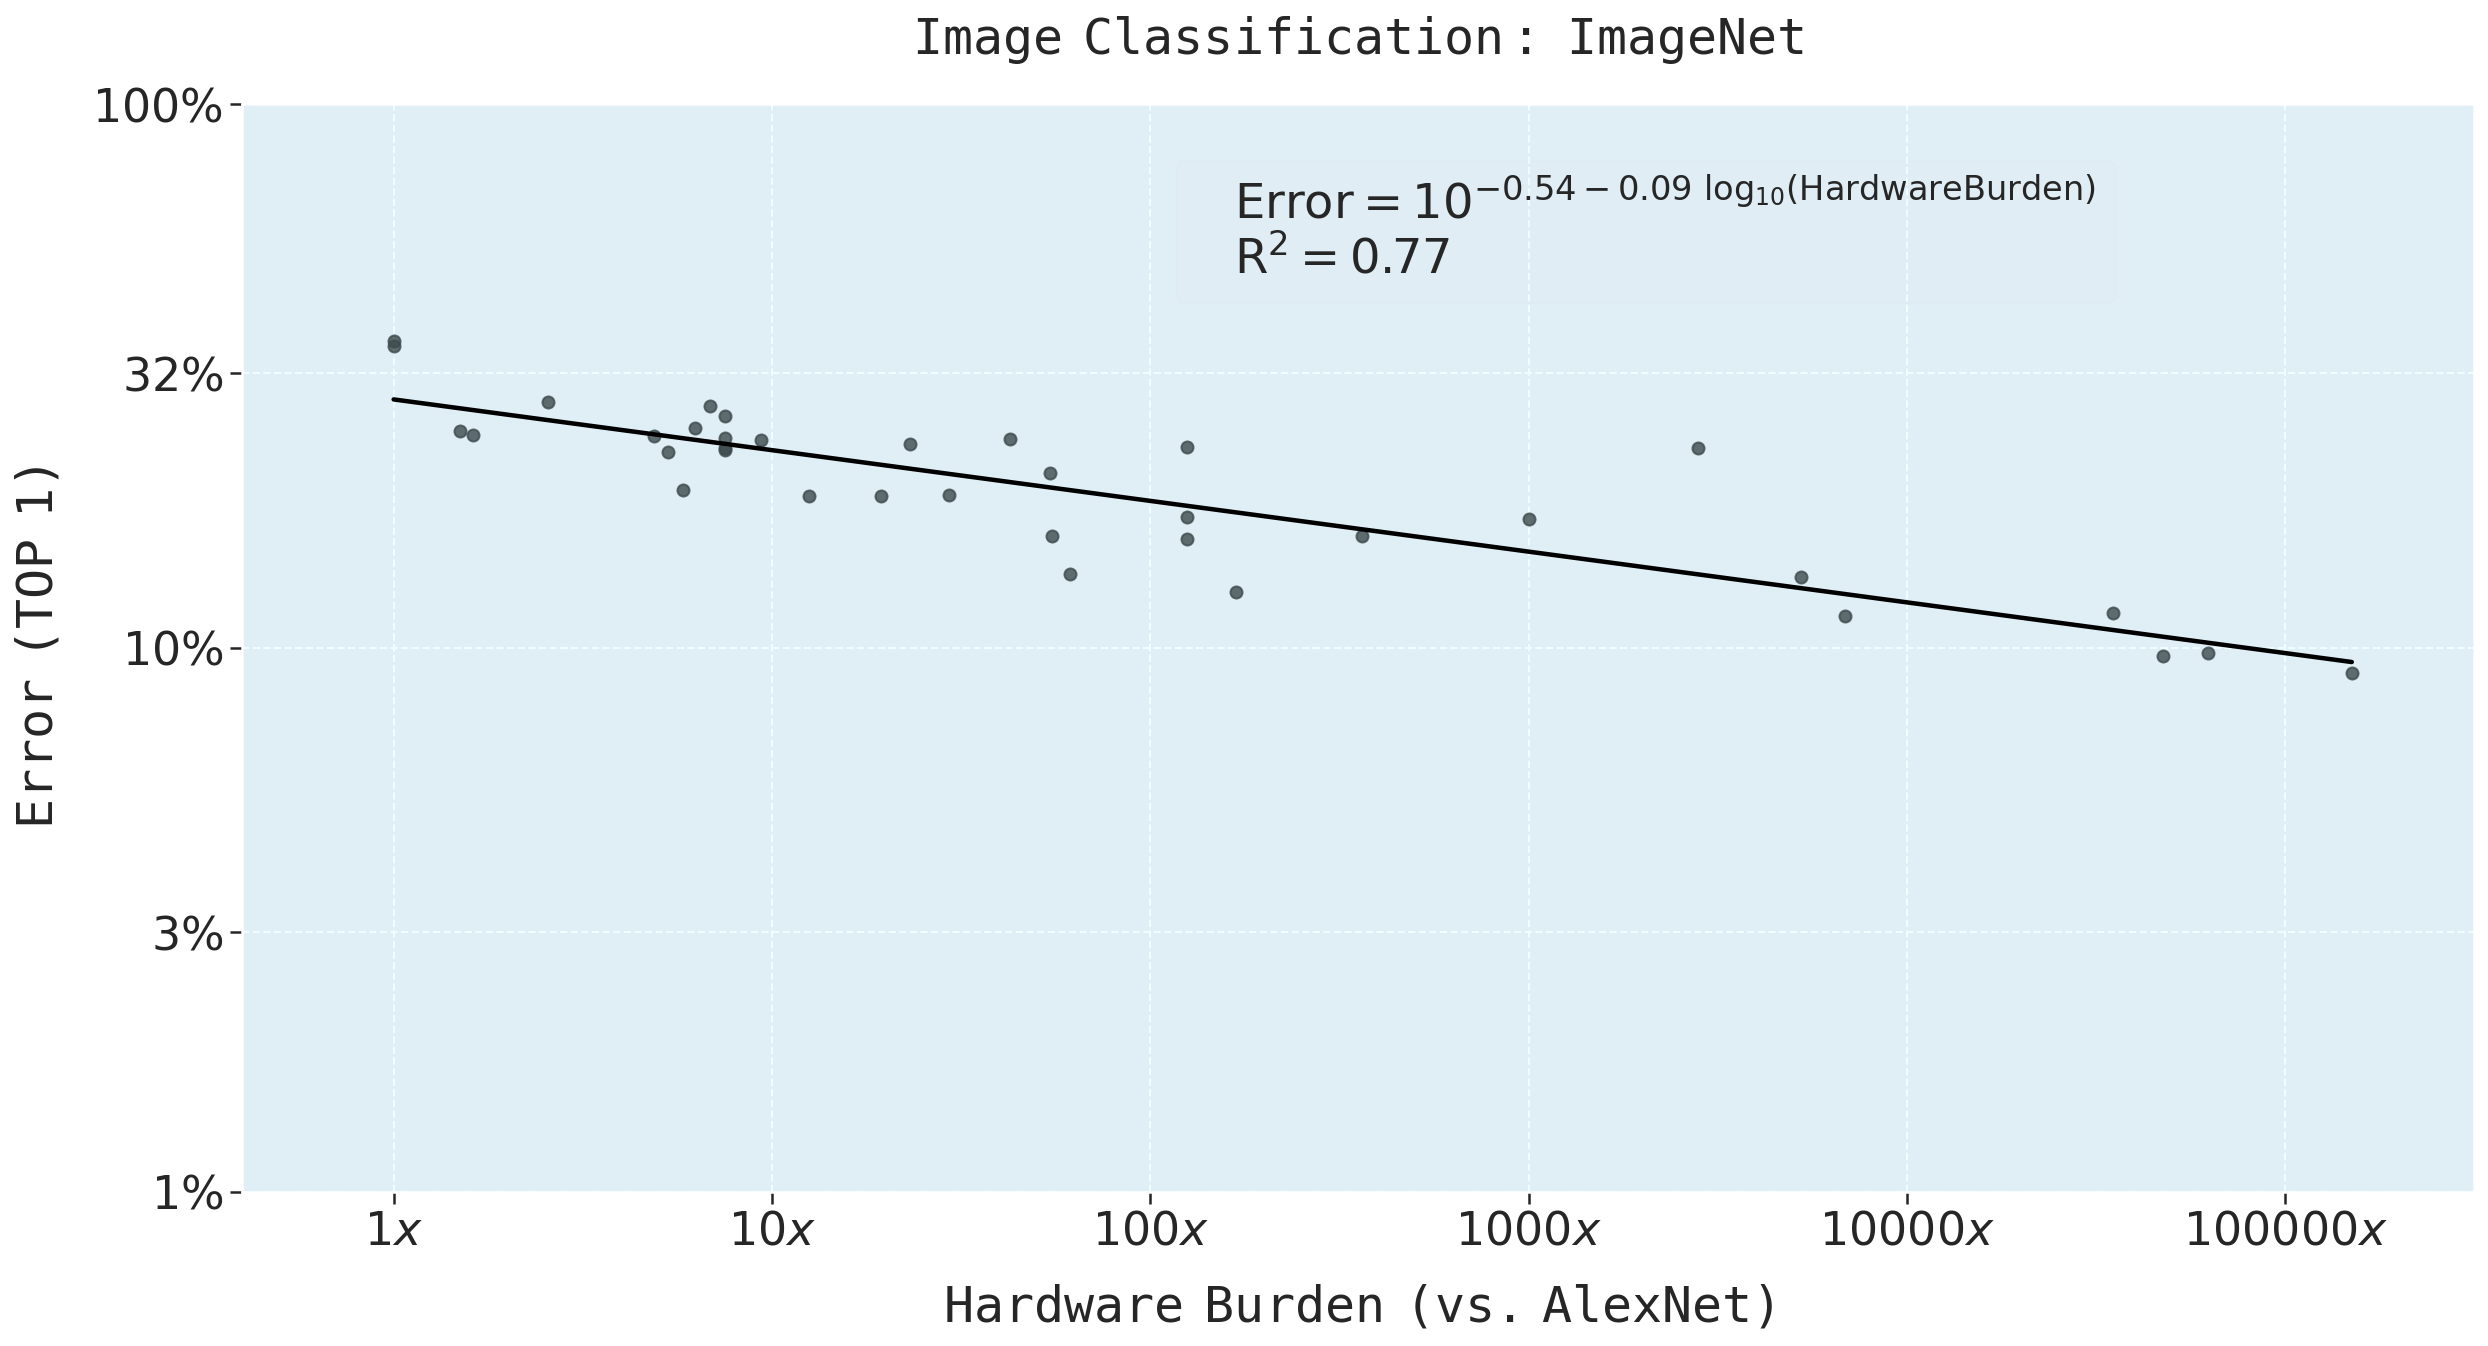

In [58]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['hw_burden_alexnet_norm']),
            y=np.log10(df['top1_error_percent']),
            color='black',
            ci = False,
            line_kws={'label':r'$\mathrm{Error}= 10^{' +
                      str(round(hw_burden__alexnet_norm__poly.params[0],2)) +
                      str(round(hw_burden__alexnet_norm__poly.params[1],2)) +
                      '\ \mathrm{log_{10}(HardwareBurden)} }$' + '\n' + 
                      r'$\mathrm{R^{2}}= ' +
                      str(round(hw_burden__alexnet_norm__poly.rsquared,2)) + '$'})

plt.title('$\mathtt{Image\ \ Classification:\ \ ImageNet}$',
          fontsize=25,
          weight='bold',
          pad=25)

plt.ylabel("$\mathtt{Error\ \ (TOP\ \ 1)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')
           
plt.xlabel("$\mathtt{Hardware\ \ Burden\ \ (vs.\ AlexNet)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.85,.97),
           handlelength=0,
           framealpha =.03,
           fontsize=24,
           markerscale=0)

plt.axhspan(-2, 0, 
            color="#c9f9ff", 
            alpha=0.3)

x = np.arange(0,6,1)

y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

x_label = ['$1x$',
           '$10x$',
           '$100x$',
           '$1000x$',
           '$10000x$',
           '$100000x$']

y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

plt.xlim(-.4, 5.5)

plt.ylim(-2,0)

plt.xticks(x, x_label,size=23)

plt.yticks(y, y_label,size=23)

plt.show()

## Conversion Regression: Network Operations into Hardware Burden

In [59]:
hw_burden__network_ops__poly = ols('I(np.log10(hardware_burden)) ~ I(np.log10(network_operations))',data=df).fit()
print(hw_burden__network_ops__poly.summary()) 

                                 OLS Regression Results                                 
Dep. Variable:     I(np.log10(hardware_burden))   R-squared:                       0.851
Model:                                      OLS   Adj. R-squared:                  0.835
Method:                           Least Squares   F-statistic:                     51.45
Date:                          Thu, 04 Aug 2022   Prob (F-statistic):           5.23e-05
Time:                                  16:00:52   Log-Likelihood:                -8.0736
No. Observations:                            11   AIC:                             20.15
Df Residuals:                                 9   BIC:                             20.94
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


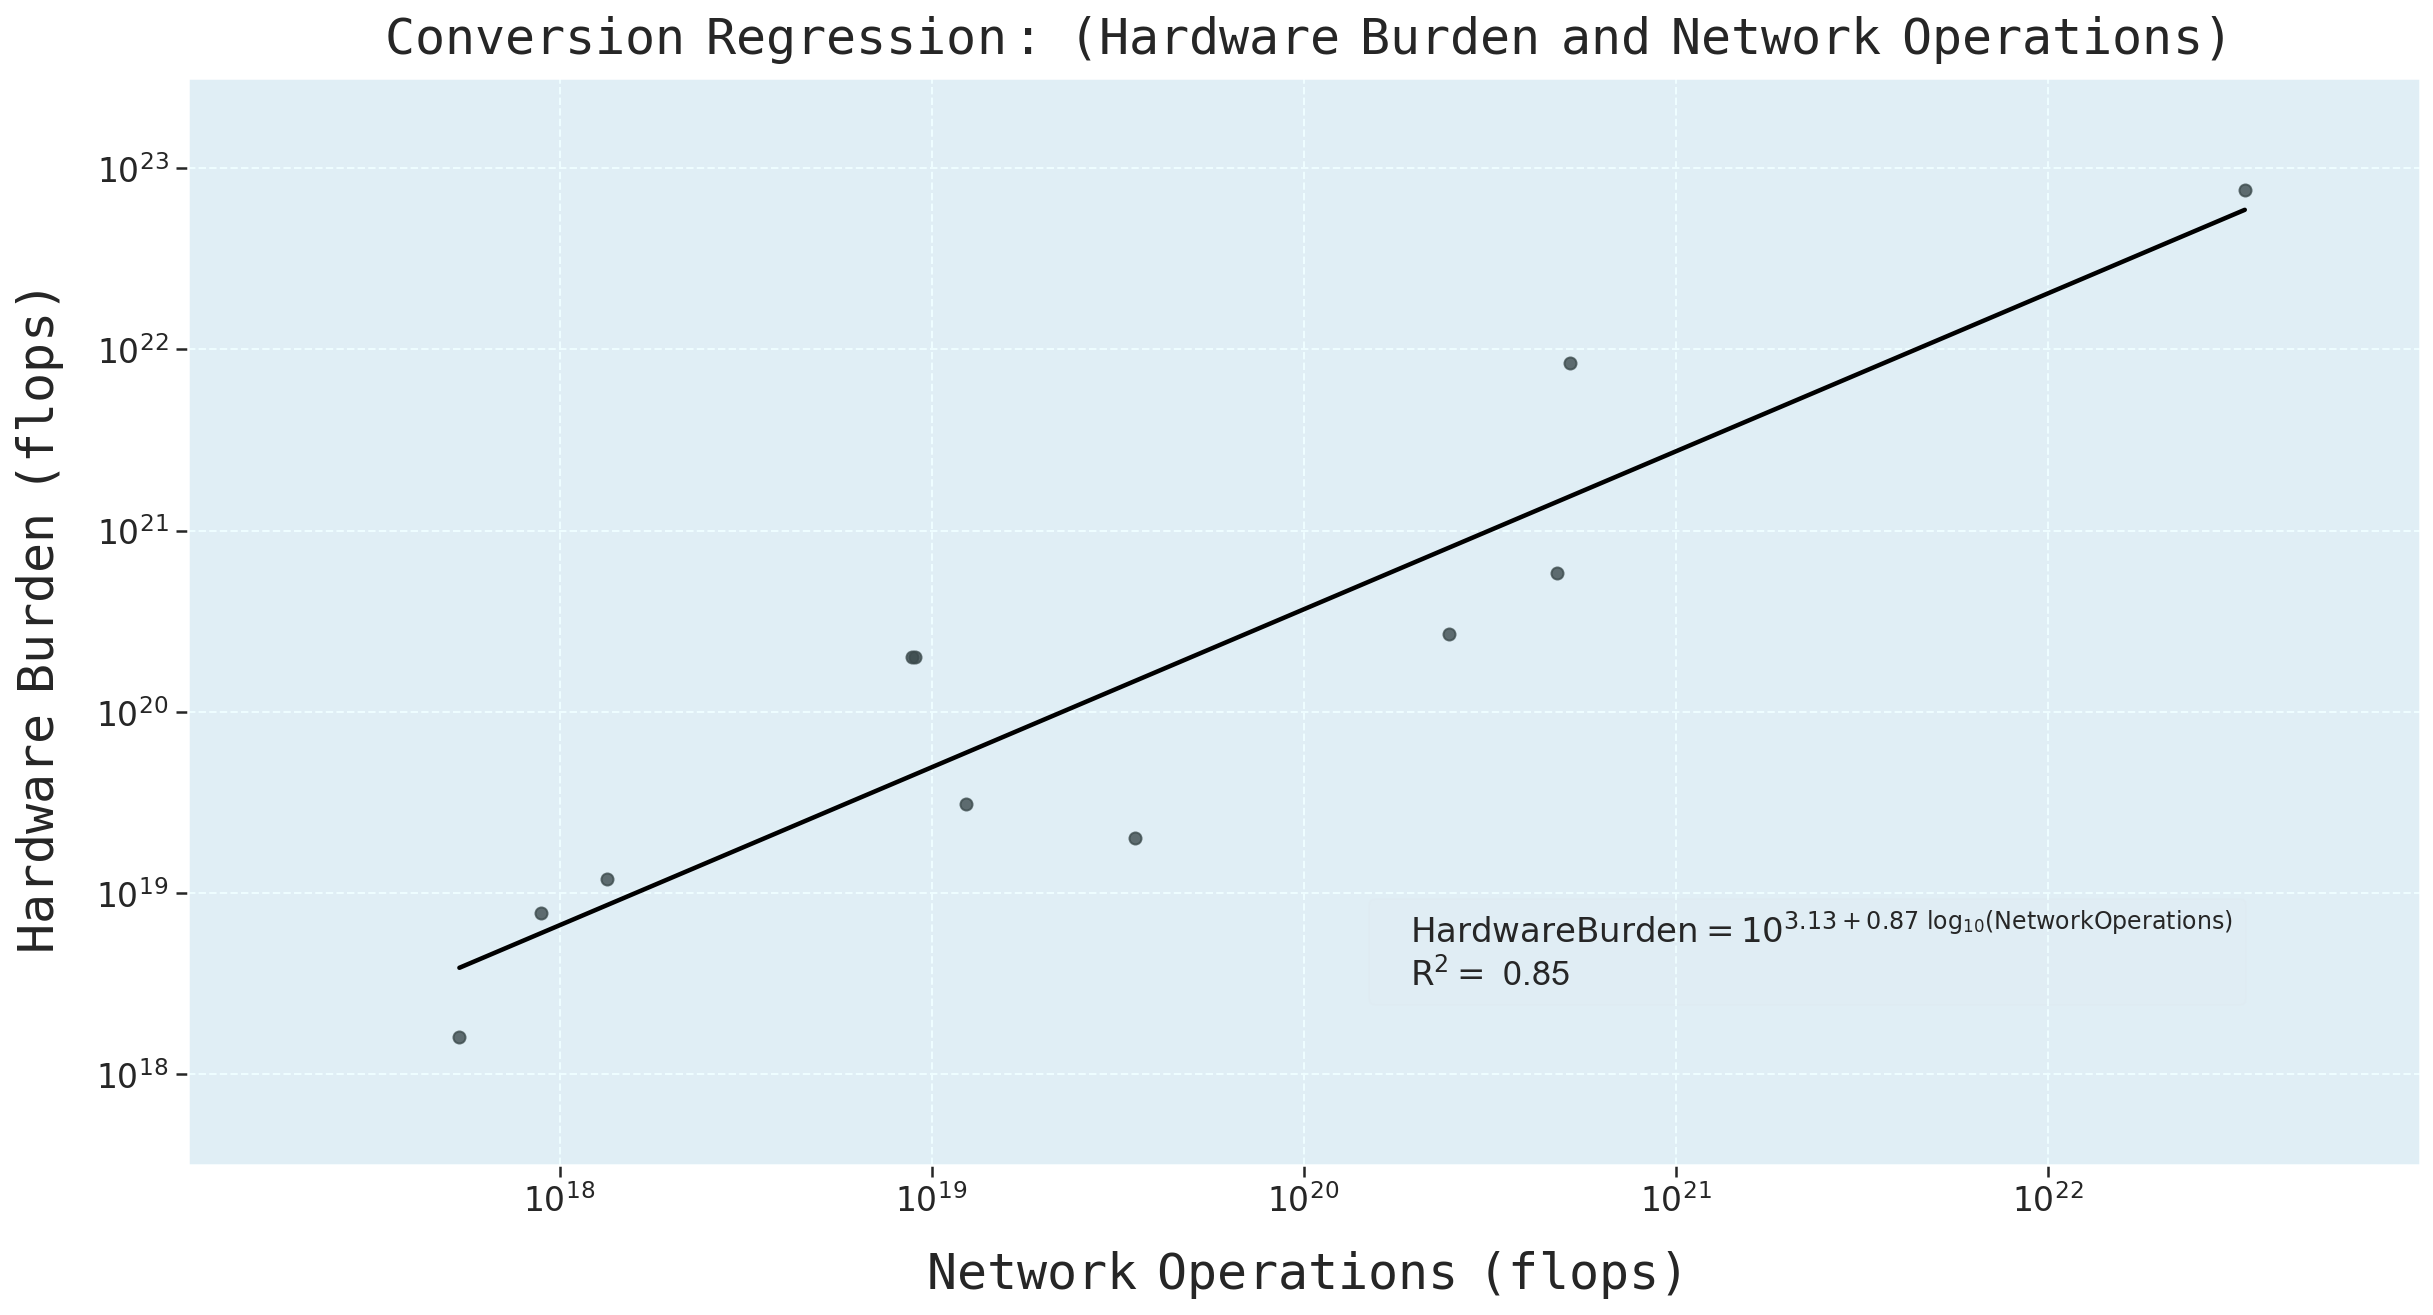

In [60]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['network_operations']),
            y=np.log10(df['hardware_burden']),
            color='black',
            ci = False,
            label=r'$\mathrm{HardwareBurden}= 10^{' +
            str(round(hw_burden__network_ops__poly.params[0],2)) + ' + ' +
            str(round(hw_burden__network_ops__poly.params[1],2)) +
            '\ \mathrm{log_{10}(NetworkOperations)} }$' + '\n' + 
            r'$\mathrm{R^{2}}=\ $' +
            str(round(hw_burden__network_ops__poly.rsquared,2)))

plt.title('$\mathtt{Conversion\ \ Regression:\ \ (Hardware\ \ Burden\ \ and\ \ Network\ \ Operations)}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{Hardware\ \ Burden\ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Network\ \ Operations\ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.93,.26),
           handlelength=0,
           framealpha =.03,
           fontsize=17,
           markerscale=0)

plt.axhspan(17.5, 23.5, 
            color="#c9f9ff", 
            alpha=0.3)

x = np.arange(18,23,1)

y = np.arange(18,24,1)

y_label = ['$10^{18}$',
           '$10^{19}$',
           '$10^{20}$',
           '$10^{21}$',
           '$10^{22}$',
           '$10^{23}$']

x_label = ['$10^{18}$',
           '$10^{19}$',
           '$10^{20}$',
           '$10^{21}$',
           '$10^{22}$']

plt.xlim(17, 23)

plt.ylim(17.5, 23.5)

plt.xticks(x, x_label)

plt.yticks(y, y_label)

plt.show()

In [61]:
def hw_burden__network_ops__formula__poly(network_ops):
    hw_burden = 10**(hw_burden__network_ops__poly.params[1] * np.log10(network_ops) + hw_burden__network_ops__poly.params[0])
    return hw_burden

In [62]:
hw_burden = 0
hw_burden_pred = 0
df['hw_burden_pred__poly'] = np.nan
df['hw_burden_consolidated__poly'] = np.nan

for i in range(len(df)):
    if (pd.isnull(df.at[i, 'hardware_burden']) == False):
        df.at[i, 'hw_burden_consolidated__poly'] = (df.at[i, 'hardware_burden'])
        hw_burden = hw_burden + 1
    if (pd.isnull(df.at[i, 'hardware_burden']) == True) & (pd.isnull(df.at[i, 'network_operations']) == False):
        df.at[i, 'hw_burden_pred__poly'] = hw_burden__network_ops__formula__poly(df.at[i, 'network_operations'])
        df.at[i, 'hw_burden_consolidated__poly'] = df.at[i, 'hw_burden_pred__poly']
        hw_burden_pred = hw_burden_pred + 1
        
print("We had " + str(hw_burden) + " hardware burden observations")
print("We predicted " + str(hw_burden_pred) + " observatios for hardware burden using network computation");

We had 36 hardware burden observations
We predicted 66 observatios for hardware burden using network computation


### Hardware Burden (Consolidated)

In [63]:
acc__hw_burden__pred__poly = ols('I(np.log10(1/top1_error_percent)) ~ I(np.log10(hw_burden_consolidated__poly))',data=df).fit()
print(acc__hw_burden__pred__poly.summary()) 

                                     OLS Regression Results                                    
Dep. Variable:     I(np.log10(1 / top1_error_percent))   R-squared:                       0.694
Model:                                             OLS   Adj. R-squared:                  0.690
Method:                                  Least Squares   F-statistic:                     226.3
Date:                                 Thu, 04 Aug 2022   Prob (F-statistic):           1.98e-27
Time:                                         16:00:53   Log-Likelihood:                 137.62
No. Observations:                                  102   AIC:                            -271.2
Df Residuals:                                      100   BIC:                            -266.0
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                                        

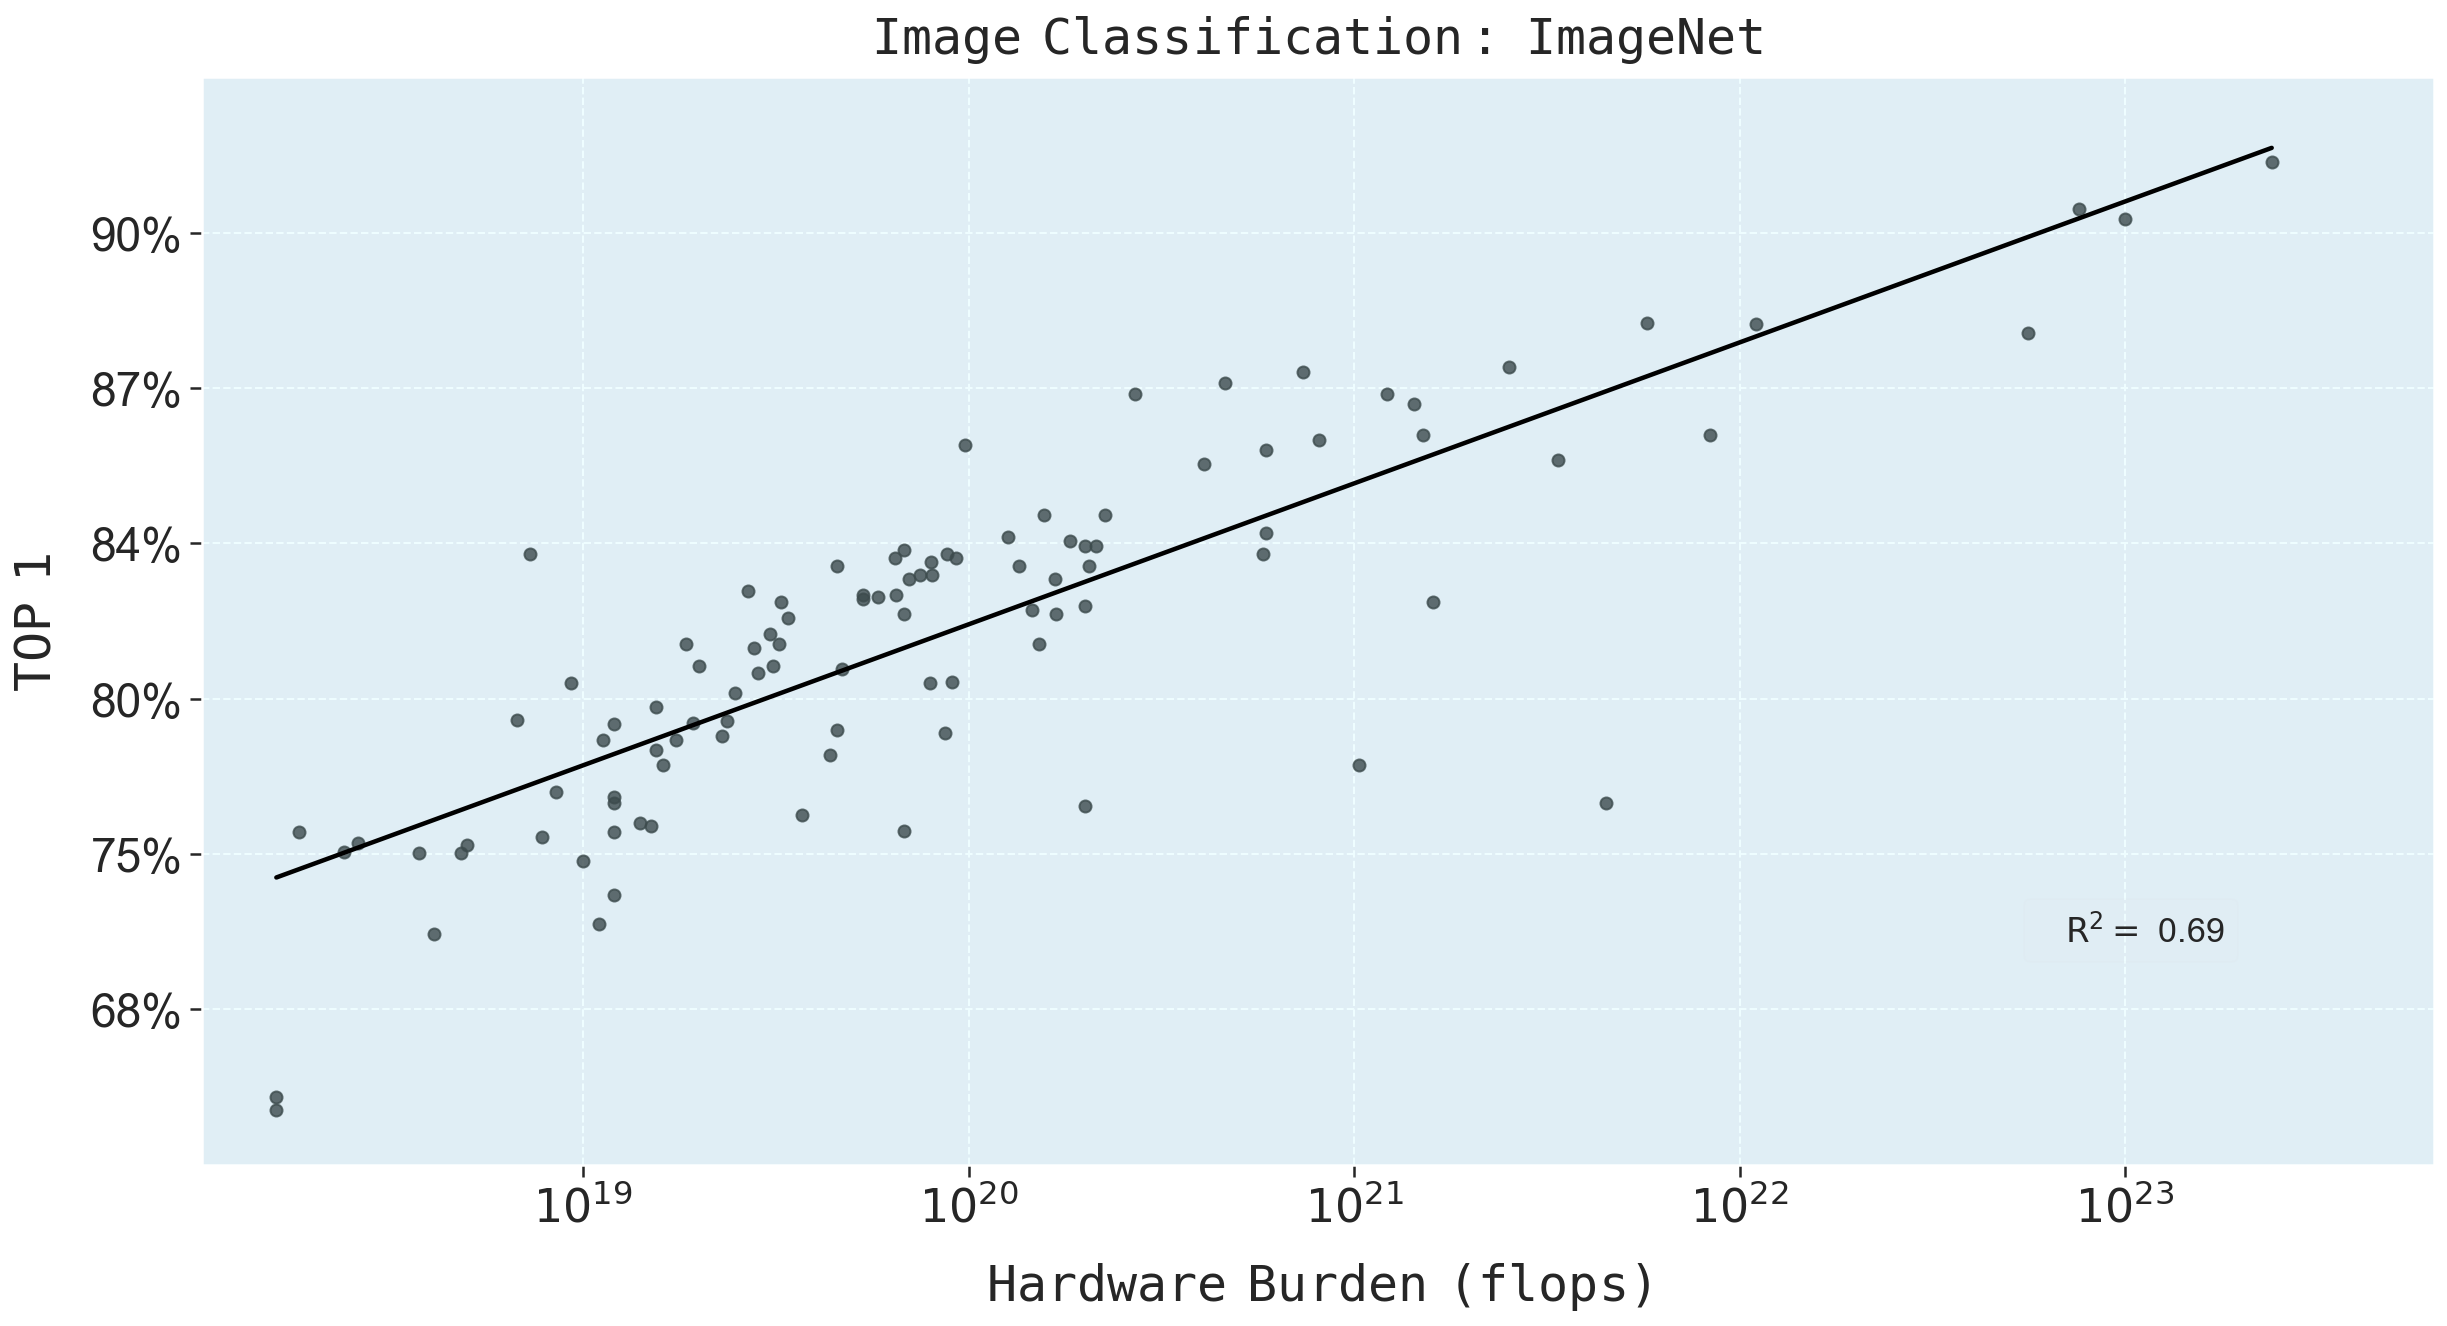

In [64]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['hw_burden_consolidated__poly']),
            y=np.log10(1/df['top1_error_percent']),
            color='black',
            ci = False,
            label=r'$\mathrm{R^{2}}=\ $' +
            str(round(acc__hw_burden__pred__poly.rsquared,2)))

plt.title('$\mathtt{Image\ \ Classification:\ \ ImageNet}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{TOP\ \ 1}$",
           fontsize=25,
           labelpad=15,
           weight='bold')
           
plt.xlabel("$\mathtt{Hardware\ \ Burden\ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.92,.26),
           handlelength=0,
           framealpha =.03,
           fontsize=17,
           markerscale=0)

plt.axhspan(.4, 1.1,
            color="#c9f9ff",
            alpha=0.3)

x = np.arange(19,24,1)

y = np.arange(.5, 1.05, .1)

x_label = ['$10^{19}$',
           '$10^{20}$',
           '$10^{21}$',
           '$10^{22}$',
           '$10^{23}$']

y_label = axes_log_conversion(y)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.xlim(18.01, 23.8)

plt.ylim(.4, 1.1)

plt.show()

In [65]:
acc__hw_burden__pred__exp = ols('I(1/top1_error_percent) ~ I(np.log10(hw_burden_consolidated__poly))',data=df).fit()
print(acc__hw_burden__pred__exp.summary()) 

                                OLS Regression Results                               
Dep. Variable:     I(1 / top1_error_percent)   R-squared:                       0.747
Model:                                   OLS   Adj. R-squared:                  0.744
Method:                        Least Squares   F-statistic:                     294.7
Date:                       Thu, 04 Aug 2022   Prob (F-statistic):           1.42e-31
Time:                               16:00:53   Log-Likelihood:                -119.06
No. Observations:                        102   AIC:                             242.1
Df Residuals:                            100   BIC:                             247.4
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

## Rubust Analysis

### Quantile Regression

In [66]:
network_ops_alexnet_quantile = smf.quantreg('I(np.log10(top1_error_percent)) ~ I(np.log10(network_ops_alexnet_norm))', df)
network_ops_alexnet_quantile_table = network_ops_alexnet_quantile.fit(q=.1)
print(network_ops_alexnet_quantile_table.summary())

                                QuantReg Regression Results                                
Dep. Variable:     I(np.log10(top1_error_percent))   Pseudo R-squared:               0.5792
Model:                                    QuantReg   Bandwidth:                     0.04751
Method:                              Least Squares   Sparsity:                       0.1494
Date:                             Thu, 04 Aug 2022   No. Observations:                   77
Time:                                     16:00:53   Df Residuals:                       75
                                                     Df Model:                            1
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.6726      0.009    -74.410      0.000      -0.691      -0.655
I(np.log10(network_ops_alexnet_norm)) 

In [67]:
quantiles = np.array([0.1])

def fit_model(q):
    network_ops_alexnet_quantile_table =  smf.quantreg('I(np.log10(top1_error_percent)) ~ I(np.log10(network_ops_alexnet_norm))', df).fit(q=q)
    return [q, network_ops_alexnet_quantile_table.params[0], network_ops_alexnet_quantile_table.params[1]] + \
            network_ops_alexnet_quantile_table.conf_int().loc['I(np.log10(network_ops_alexnet_norm))'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('I(np.log10(top1_error_percent)) ~ I(np.log10(network_ops_alexnet_norm))', df).fit()
ols_ci = ols.conf_int().loc['I(np.log10(network_ops_alexnet_norm))'].tolist()
ols = dict(a = ols.params[0],
           b = ols.params[1],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

     q         a         b        lb        ub
0  0.1 -0.672607 -0.084051 -0.093565 -0.074538
{'a': -0.6285425295038164, 'b': -0.08360854939433231, 'lb': -0.09559060195299408, 'ub': -0.07162649683567053}


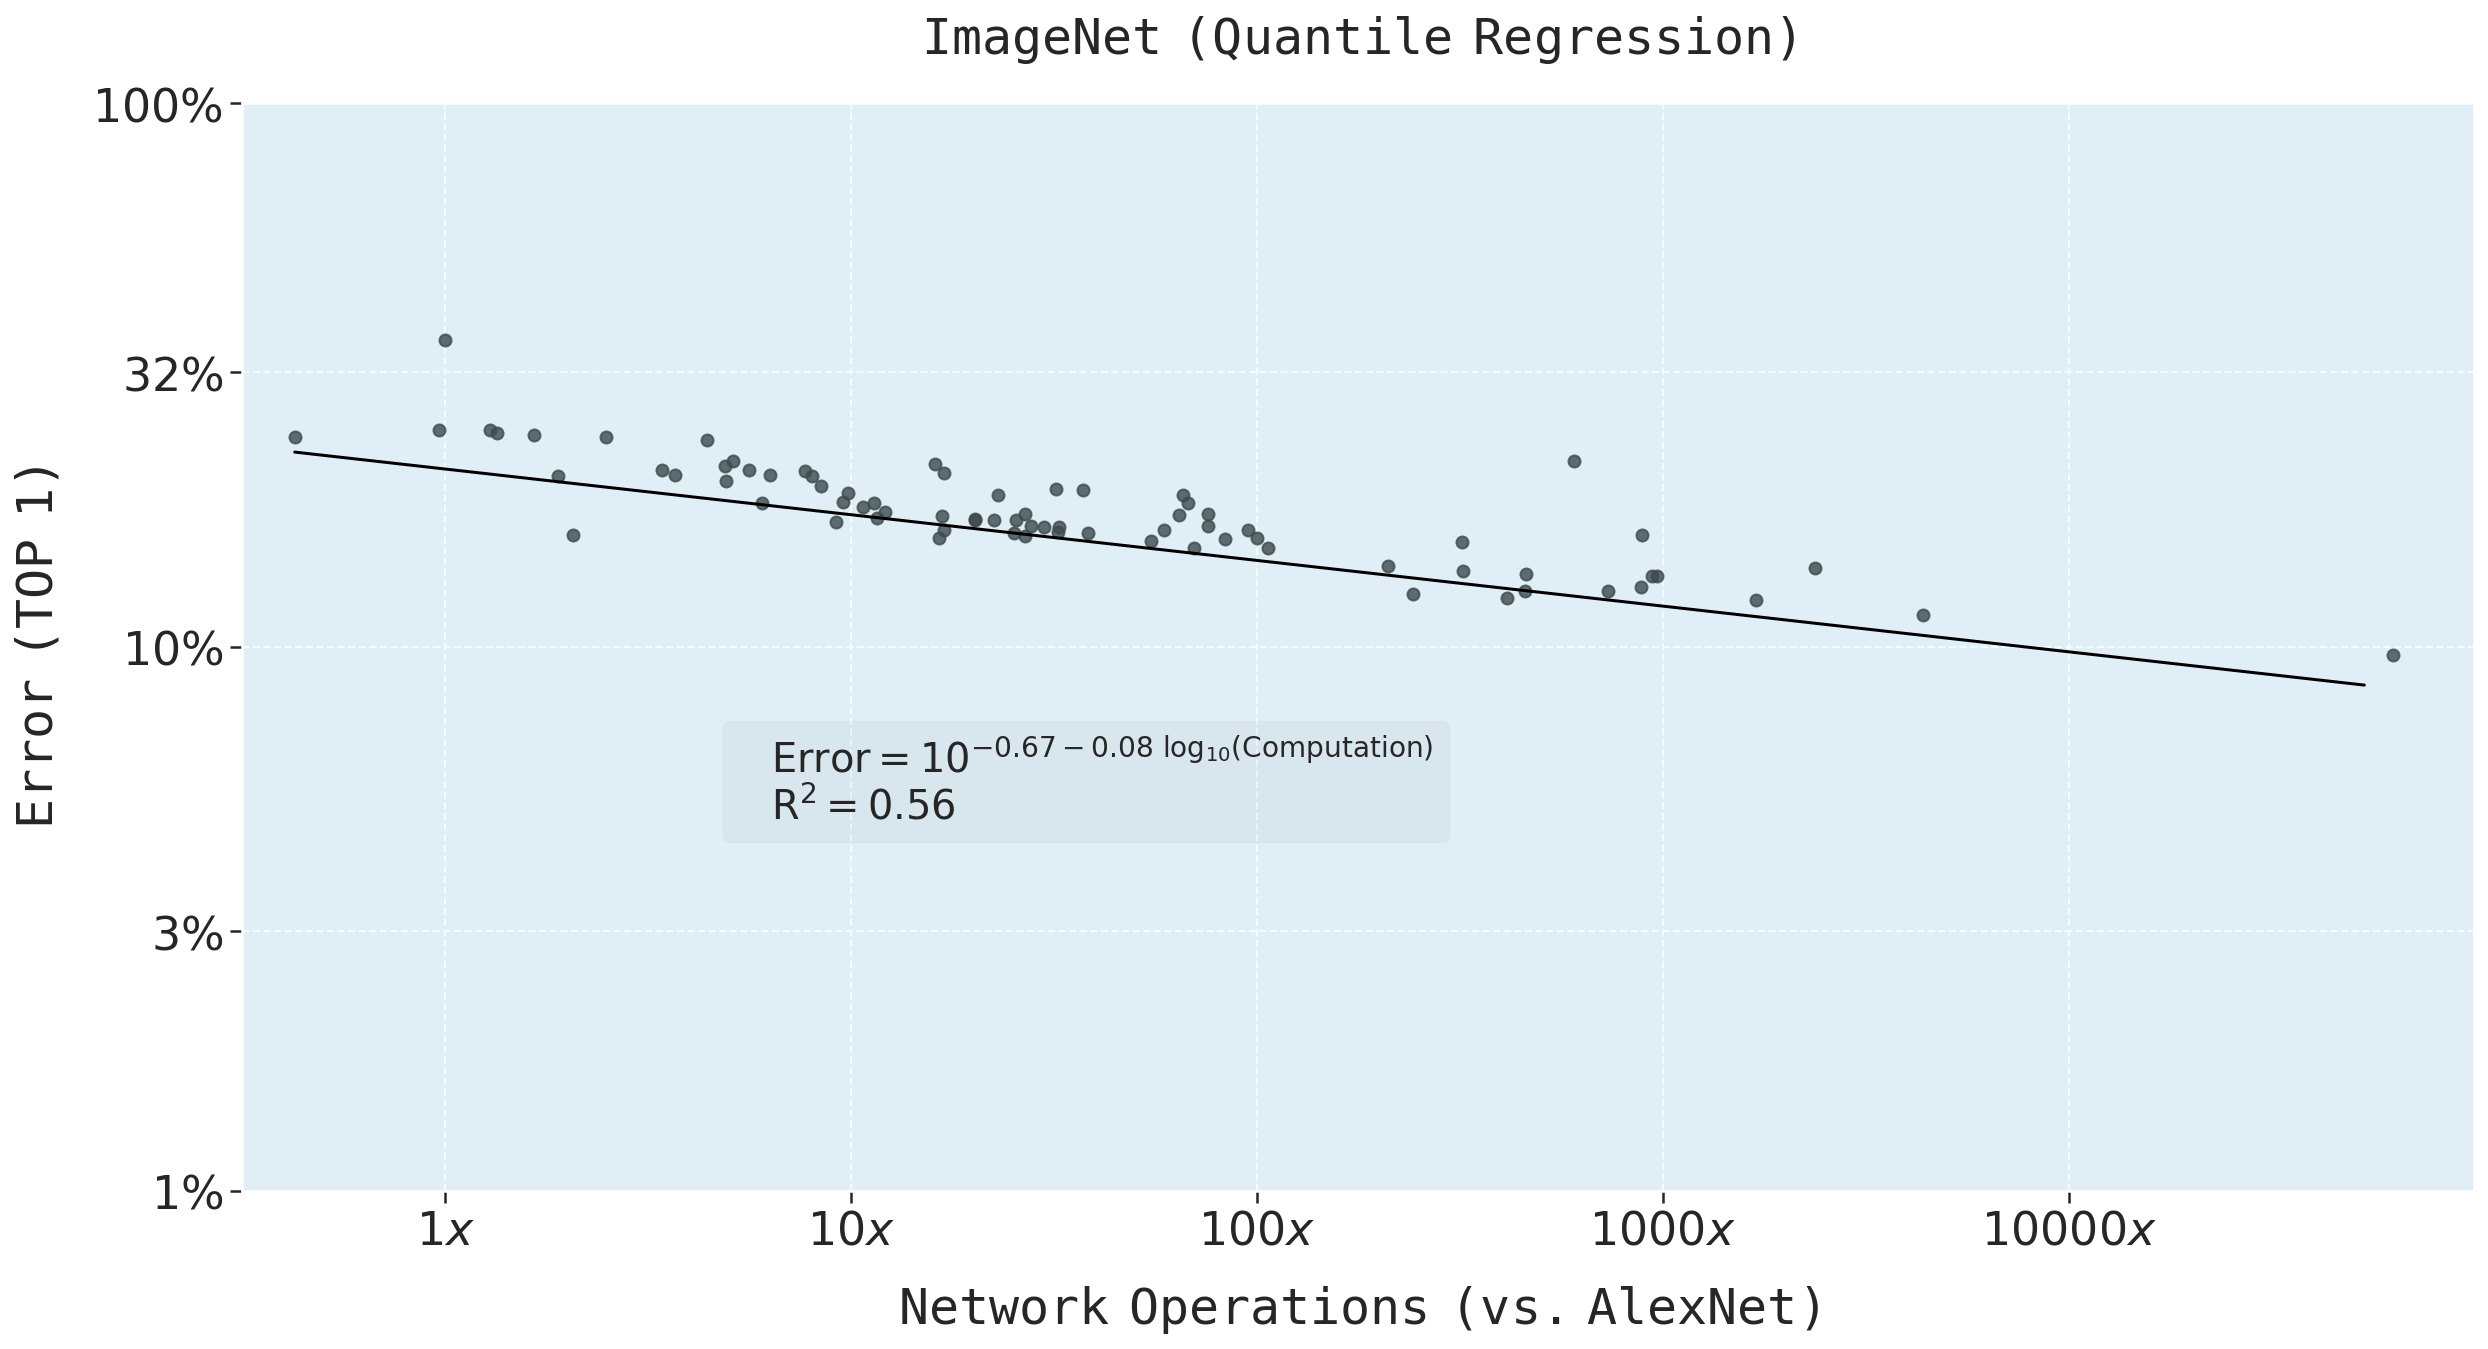

In [68]:
x = np.arange(np.log10(df['network_ops_alexnet_norm']).min(),
              np.log10(df['network_ops_alexnet_norm']).max(),
              0.1)

get_y = lambda a, b: a + b * x

fig = plt.figure(figsize=(20, 10))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    plt.plot(x, y,
            color='black',
            label=r'$\mathrm{Error}= 10^{' +
                   str(round(network_ops_alexnet_quantile_table.params[0],2)) +
                   str(round(network_ops_alexnet_quantile_table.params[1],2)) +
                   '\ \mathrm{log_{10}(Computation)} }$' + '\n' + 
                   r'$\mathrm{R^{2}}= 0.56$')
    
y = get_y(ols['a'], ols['b'])

plt.scatter(np.log10(df['network_ops_alexnet_norm']),
           np.log10(df['top1_error_percent']),
           alpha=.8, color = 'black')

plt.title('$\mathtt{ImageNet\ \ (Quantile\ \ Regression)}$',
          fontsize=25,
          weight='bold',
          pad=25)

plt.ylabel("$\mathtt{Error\ \ (TOP\ \ 1)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Network\ \ Operations\ \ (vs.\ AlexNet)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.55,.45),
           handlelength=0,
           facecolor = 'black',
           framealpha = .03,
           fontsize=20)

plt.axhspan(-2, 0,
            color="#c9f9ff", 
            alpha=0.3)

x = np.arange(0,5,1)

y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

x_label = ['$1x$',
           '$10x$',
           '$100x$',
           '$1000x$',
           '$10000x$']

y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

plt.xlim(-0.5, 5)

plt.ylim(-2, 0)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

### Scaling Studies

In [69]:
df['network_ops_alexnet_norm_logged'] = np.log10(df['network_ops_alexnet_norm'])

y_alex = np.log10(df['top1_error_percent'])

scaling_fig_df = df.dropna(subset=['top1_error_percent','network_ops_alexnet_norm_logged'])
x_second_fig = scaling_fig_df['network_ops_alexnet_norm_logged']
y_second_fig = np.log10(scaling_fig_df['top1_error_percent'])

In [70]:
df['ops_forward_pass_alexnet_norm_logged'] = np.log10(df['ops_forward_pass_alexnet_norm'])

x_alex_ops_fp = df['ops_forward_pass_alexnet_norm_logged']
y_alex_ops_fp = np.log10(df['top1_error_percent'])

scaling_fig_df_ops_fp = df.dropna(subset=['top1_error_percent','ops_forward_pass_alexnet_norm_logged'])
y_second_fig_ops_fp = np.log10(scaling_fig_df_ops_fp['top1_error_percent'])
x_second_fig_ops_fp = scaling_fig_df_ops_fp['ops_forward_pass_alexnet_norm_logged']

df['alpha_1_4_ops_fp'] = y_second_fig - (-1/4 * x_second_fig_ops_fp)
df['alpha_1_6_ops_fp'] = y_second_fig - (-1/6 * x_second_fig_ops_fp)
df['alpha_1_8_ops_fp'] = y_second_fig - (-1/8 * x_second_fig_ops_fp)
df['alpha_1_10_ops_fp'] = y_second_fig - (-1/10 * x_second_fig_ops_fp)
df['alpha_1_12_ops_fp'] = y_second_fig - (-1/12 * x_second_fig_ops_fp)

alpha_1_4_ops_fp = df['alpha_1_4_ops_fp'].mean()
alpha_1_6_ops_fp = df['alpha_1_6_ops_fp'].mean()
alpha_1_8_ops_fp = df['alpha_1_8_ops_fp'].mean()
alpha_1_10_ops_fp = df['alpha_1_10_ops_fp'].mean()
alpha_1_12_ops_fp = df['alpha_1_12_ops_fp'].mean()

df['alpha_all_models_ops_fp'] = y_second_fig_ops_fp - (1/(1/ops_forward_pass__alexnet_norm__poly.params[1]) * x_second_fig_ops_fp)

alpha_all_models_ops_fp = df['alpha_all_models_ops_fp'].mean()

y_pred_all_models_ops_fp = (x_second_fig_ops_fp * 1/(1/ops_forward_pass__alexnet_norm__poly.params[1])) + alpha_all_models_ops_fp

In [71]:
efficientnet = {'model': ['EfficientNet-B0',
               'EfficientNet-B1',
               'EfficientNet-B2',
               'EfficientNet-B3',
               'EfficientNet-B4',
               'EfficientNet-B5',
               'EfficientNet-B6',
               'EfficientNet-B7'],
                 'top_1': [0.773,
                           0.792,
                           0.803,
                           0.817,
                           0.83,
                           0.837,
                           0.842,
                           0.844],
                 'ops_forward_pass': [0.39 * 10**(9),
                                0.7  * 10**(9),
                                1    * 10**(9),
                                1.8  * 10**(9),
                                4.2  * 10**(9),
                                9.9  * 10**(9),
                                19   * 10**(9),
                                37   * 10**(9)]}

data_efficientnet = pd.DataFrame(efficientnet)
data_efficientnet['top_1_error'] = 1 - data_efficientnet['top_1']


resnet = {'model': ['ResNet18',
                    'ResNet34',
                    'ResNet50',
                    'ResNet101',
                    'ResNet152'],
          'top_1': [0.698,
                    0.733,
                    0.762,
                    0.774,
                    0.783],
     'ops_forward_pass': [1.8  * 10**(9),
                    3.6  * 10**(9),
                    3.8  * 10**(9),
                    7.6  * 10**(9),
                    11.3 * 10**(9)]}

data_resnet = pd.DataFrame(resnet)
data_resnet['top_1_error'] = 1 - data_resnet['top_1']

dpn = {'model': ['DPN-92',
                 'DPN-98',
                 'DPN-131'],
       'top_1': [0.793,
                 0.798,
                 0.8007],
       'ops_forward_pass': [6.5   * 10**(9),
                      11.7  * 10**(9),
                      16    * 10**(9)]}

data_dpn = pd.DataFrame(dpn)
data_dpn['top_1_error'] = 1 - data_dpn['top_1']

nasnet = {'model': ['NASNet-A (4 @ 1056)',
                    'NASNet-A (5 @ 1538)',
                    'NASNet-A (7 @ 1920)',
                    'NASNet-A (6 @ 4032)'],
          'top_1': [0.74,
                    0.786,
                    0.808,
                    0.872],
          'ops_forward_pass': [0.564  * 10**(9),
                         2.35   * 10**(9),
                         4.93   * 10**(9),
                         23.8   * 10**(9)]}

data_nasnet = pd.DataFrame(nasnet)
data_nasnet['top_1_error'] = 1 - data_nasnet['top_1']

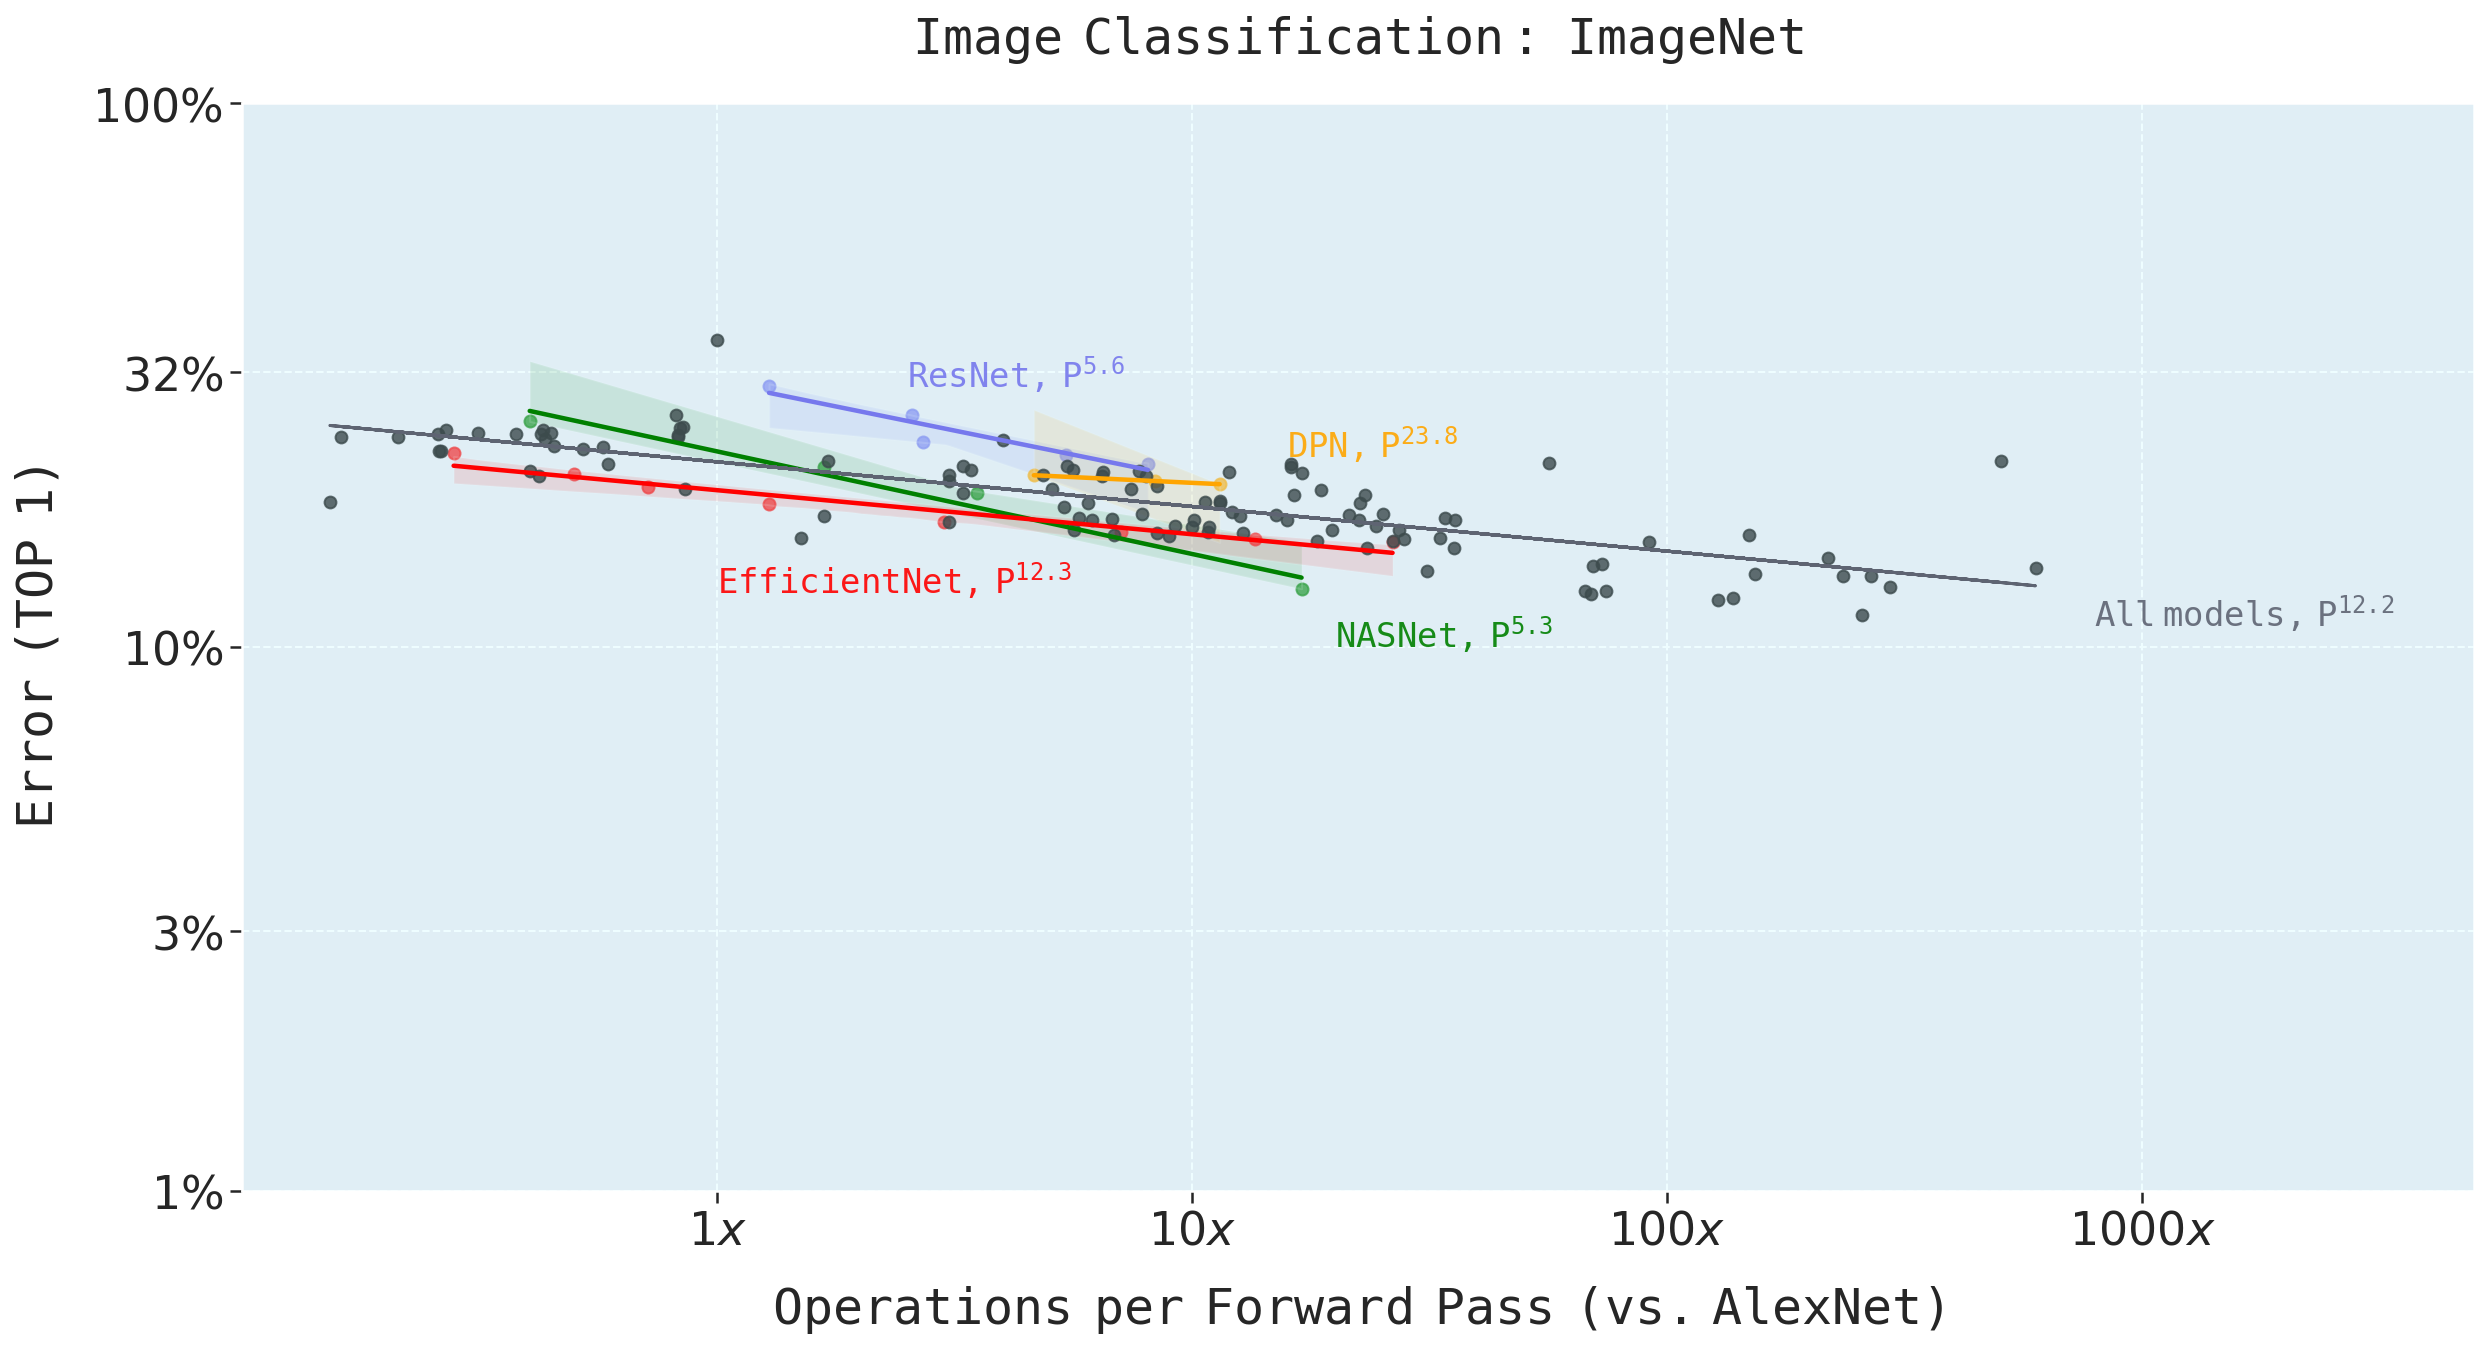

In [72]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(data_nasnet['ops_forward_pass']/alexnet_data['ops_forward_pass'].values),
            y=np.log10(data_nasnet['top_1_error']),
            color='green',
            label='$\mathtt{NASNet}$')

plt.annotate('$\mathtt{NASNet,\ P^{5.3}}$',
             xy=(1.3,-1),
             fontsize=17,
             alpha=0.9,
             weight='bold',
             color='green')


sns.regplot(x=np.log10(data_resnet['ops_forward_pass']/alexnet_data['ops_forward_pass'].values),
            y=np.log10(data_resnet['top_1_error']),
            color='#7678ed',
            label='$\mathtt{ResNet}$')

plt.annotate('$\mathtt{ResNet,\ P^{5.6}}$',
             xy=(.4,-.52),
             fontsize=17,
             alpha=0.9,
             weight='bold',
             color='#7678ed')


sns.regplot(x=np.log10(data_efficientnet['ops_forward_pass']/alexnet_data['ops_forward_pass'].values),
            y=np.log10(data_efficientnet['top_1_error']),
            color='red',
            label='$\mathtt{EfficientNet}$')

plt.annotate('$\mathtt{EfficientNet,\ P^{12.3}}$',
             xy=(0,-.9),
             fontsize=17,
             alpha=0.9,
             weight='bold',
             color='red')


sns.regplot(x=np.log10(data_dpn['ops_forward_pass']/alexnet_data['ops_forward_pass'].values),
            y=np.log10(data_dpn['top_1_error']),
            color='orange',
            label='$\mathtt{DPN}$')

plt.annotate('$\mathtt{DPN,\ P^{23.8}}$',
             xy=(1.2,-.65),
             fontsize=17,
             alpha=0.9,
             weight='bold',
             color='orange')

plt.annotate('$\mathtt{All\ models,\ P^{' +
             str(round(abs(1/ops_forward_pass__alexnet_norm__poly.params[1]), 1)) + '}}$',
             weight='bold',
             xy=(2.9, -.96),
             fontsize=17,
             alpha=0.9,
             color='#5e6472')

plt.scatter(x_alex_ops_fp,
            y_alex_ops_fp,
            color='black',
            alpha=.8,
            s = 35)

plt.plot(x_second_fig_ops_fp, y_pred_all_models_ops_fp,
         color='#5e6472')

plt.title('$\mathtt{Image\ \ Classification:\ \ ImageNet}$',
          fontsize=25,
          weight='bold',
          pad=25)

plt.ylabel("$\mathtt{Error\ \ (TOP\ \ 1)}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Operations\ \ per\ \ Forward\ \ Pass\ \ (vs.\ AlexNet)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.axhspan(-2, 0, 
            color="#c9f9ff", 
            alpha=0.3)

x_label = ['$1x$',
           '$10x$',
           '$100x$',
           '$1000x$']
           
y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

x = np.arange(0,4,1)

y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

plt.xlim(-1, 3.7)

plt.ylim(-2,0)

plt.xticks(x, x_label,size=23)

plt.yticks(y, y_label,size=23)

plt.show()